# Toronto Mental Health & Green Space Analysis: Cluster-Level Approach


In [2]:
# Imports and CRS Setup
import os
import pandas as pd
import geopandas as gpd
import json
from shapely.geometry import shape
import matplotlib.pyplot as plt

# Standard CRS
TARGET_CRS = "EPSG:4326"

## Create the Neighbourhood → Cluster Lookup Template (lookup.xlsx)

In [ ]:
BASE_DIR    = "/Users/renudinesh/Final-Project"
DATA_DIR    = os.path.join(BASE_DIR, "data")
NEIGH_DIR   = os.path.join(DATA_DIR, "Neighbourhoods - 4326")
SHAPEFILE   = os.path.join(NEIGH_DIR, "Neighbourhoods - 4326.shp")
GREEN_CSV   = os.path.join(DATA_DIR, "Green Spaces.csv")
MENTAL_XLS  = os.path.join(DATA_DIR, "Mental health and substance use download.xlsx")
PROFILES_XLS= os.path.join(DATA_DIR, "neighbourhood-profiles-2021.xlsx")

# Check that files exist
for path in [SHAPEFILE, GREEN_CSV, MENTAL_XLS, PROFILES_XLS]:
    print(path, "Yes" if os.path.exists(path) else "No")




/Users/renudinesh/Final-Project/data/Neighbourhoods - 4326/Neighbourhoods - 4326.shp Yes
/Users/renudinesh/Final-Project/data/Green Spaces.csv Yes
/Users/renudinesh/Final-Project/data/Mental health and substance use download.xlsx Yes
/Users/renudinesh/Final-Project/data/neighbourhood-profiles-2021.xlsx Yes


In [4]:
neigh_gdf = gpd.read_file(SHAPEFILE).to_crs(TARGET_CRS)
# Rename for consistency
neigh_gdf = neigh_gdf.rename(columns={"AREA_NA7": "AREA_NAME"})
display(neigh_gdf.head())

,_id1,AREA_ID2,AREA_AT3,PARENT_4,AREA_SH5,AREA_LO6,AREA_NAME,AREA_DE8,CLASSIF9,CLASSIF10,OBJECTI11,geometry
0,1,2502366,26022881,NaN,174,174,South Eglinton-Davisville,South Eglinton-Davisville (174),Not an NIA or Emerging Neighbourhood,NA,17824737.0,"POLYGON ((-79.38635 43.69783, -79.38623 43.697..."
1,2,2502365,26022880,NaN,173,173,North Toronto,North Toronto (173),Not an NIA or Emerging Neighbourhood,NA,17824753.0,"POLYGON ((-79.39744 43.70693, -79.39837 43.706..."
2,3,2502364,26022879,NaN,172,172,Dovercourt Village,Dovercourt Village (172),Not an NIA or Emerging Neighbourhood,NA,17824769.0,"POLYGON ((-79.43411 43.66015, -79.43537 43.659..."
3,4,2502363,26022878,NaN,171,171,Junction-Wallace Emerson,Junction-Wallace Emerson (171),Not an NIA or Emerging Neighbourhood,NA,17824785.0,"POLYGON ((-79.4387 43.66766, -79.43841 43.6669..."
4,5,2502362,26022877,NaN,170,170,Yonge-Bay Corridor,Yonge-Bay Corridor (170),Not an NIA or Emerging Neighbourhood,NA,17824801.0,"POLYGON ((-79.38404 43.64497, -79.38502 43.644..."


In [5]:
import os
import pandas as pd
import geopandas as gpd

# 2) Define output file for lookup template
LOOKUP_XLSX = os.path.join(DATA_DIR, "nh_to_cluster.xlsx")

# 3) Read shapefile and extract all neighbourhood names
neighbourhoods = sorted(neigh_gdf["AREA_NAME"].unique())

# 4) Create the blank lookup DataFrame
lookup_df = pd.DataFrame({
    "AREA_NAME": neighbourhoods,
    "ClusterName": [""] * len(neighbourhoods)
})

# 5) Save as Excel file
lookup_df.to_excel(LOOKUP_XLSX, index=False)
print("Blank lookup template written to:", LOOKUP_XLSX)

Blank lookup template written to: /Users/renudinesh/Final-Project/data/nh_to_cluster.xlsx


# Table was manually filled in after creating template

In [7]:
# Load filled-in lookup table
lookup_filled = pd.read_excel(LOOKUP_XLSX)

# Merge onto GeoDataFrame
merged = neigh_gdf.merge(
    lookup_filled,
    on="AREA_NAME",
    how="left"
)

#  Check for missing clusters
missing = merged[merged["ClusterName"].isna()]
if not missing.empty:
    print("These neighbourhoods are missing cluster assignments:", missing["AREA_NAME"].tolist())
    raise ValueError("Please fill all ClusterName values.")

# Dissolve by ClusterName to create 7 clusters
clusters_gdf = (
    merged
    .dissolve(by="ClusterName", as_index=False, aggfunc="first")
    .reset_index(drop=True)
)

# Save the dissolved clusters as a new shapefile for later use
out_shp = os.path.join(DATA_DIR, "Toronto_7_Clusters.shp")
clusters_gdf.to_file(out_shp)
print("Saved 7-region shapefile:", out_shp)


Saved 7-region shapefile: /Users/renudinesh/Final-Project/data/Toronto_7_Clusters.shp


/var/folders/zq/xymt9xrj2js7qhy28pxqjr140000gn/T/ipykernel_31275/3623393989.py:26: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  clusters_gdf.to_file(out_shp)
/opt/homebrew/Caskroom/miniforge/base/envs/exam_env2/lib/python3.11/site-packages/pyogrio/raw.py:723: RuntimeWarning: Normalized/laundered field name: 'ClusterName' to 'ClusterNam'
  ogr_write(


# Viisualize the Clusters

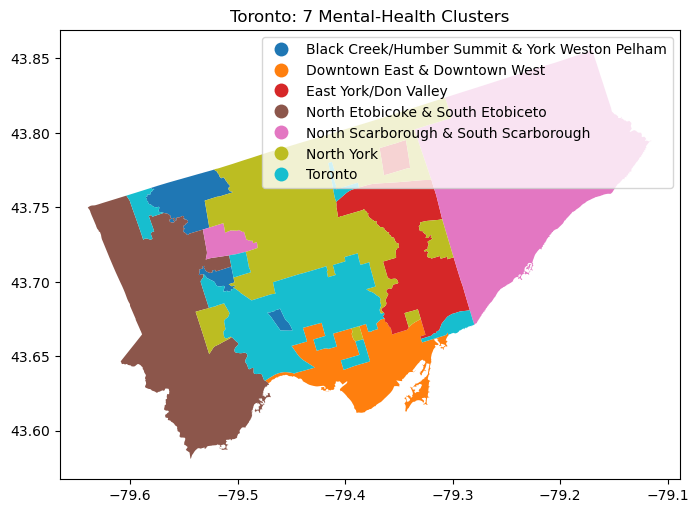

In [8]:
clusters_gdf.plot(column="ClusterName", legend=True, figsize=(8, 6))
plt.title("Toronto: 7 Mental-Health Clusters")
plt.show()


# Parse and Load Green Spaces

In [9]:
green_df = pd.read_csv(GREEN_CSV)
green_df['geometry'] = green_df['geometry'].apply(lambda s: shape(json.loads(s)))
green_gdf = gpd.GeoDataFrame(green_df, geometry='geometry', crs=TARGET_CRS)


# Parks

In [10]:
import json
from shapely.geometry import shape

parks_df = pd.read_csv(GREEN_CSV)
parks_df['geometry'] = parks_df['geometry'].apply(lambda s: shape(json.loads(s)))
parks_gdf = gpd.GeoDataFrame(parks_df, geometry='geometry', crs="EPSG:4326")


# Spatial Join: Assign Parks to Clusters

In [11]:
parks_joined = gpd.sjoin(
    green_gdf,
    clusters_gdf,
    how="left",
    predicate="within"
)

# Aggregrate: Count Parks Per Cluster

In [12]:
park_counts = (
    parks_joined.groupby('ClusterName')
    .size()
    .reset_index(name='Park_Count')
)
clusters_gdf = clusters_gdf.merge(park_counts, on="ClusterName", how="left")
clusters_gdf["Park_Count"] = clusters_gdf["Park_Count"].fillna(0).astype(int)
print(clusters_gdf[["ClusterName", "Park_Count"]])


                                      ClusterName  Park_Count
0  Black Creek/Humber Summit & York Weston Pelham          69
1                   Downtown East & Downtown West         294
2                            East York/Don Valley         252
3               North Etobicoke & South Etobiceto         468
4           North Scarborough & South Scarborough         986
5                                      North York         568
6                                         Toronto         491


# Integrate Mental Health Data

In [13]:
mh_df = pd.read_excel(MENTAL_XLS, sheet_name=0)
mh_clusters = mh_df[mh_df["Stratifier"] == "Sub_Toronto_Geography_Clusters"].copy()

# Coping with stress
coping = mh_clusters[mh_clusters["Indicator Name"].str.contains("Coping")][["Subgroup", "Value"]]
coping = coping.rename(columns={"Subgroup": "ClusterName", "Value": "Coping_Percent"})

# Life stress
lifestress = mh_clusters[mh_clusters["Indicator Name"].str.contains("Life stress")][["Subgroup", "Value"]]
lifestress = lifestress.rename(columns={"Subgroup": "ClusterName", "Value": "LifeStress_Percent"})

# Merge both metrics
mh_metrics = pd.merge(coping, lifestress, on="ClusterName", how="outer")
clusters_gdf = clusters_gdf.merge(mh_metrics, on="ClusterName", how="left")


# Final Visualizations

Coping With Stress Map

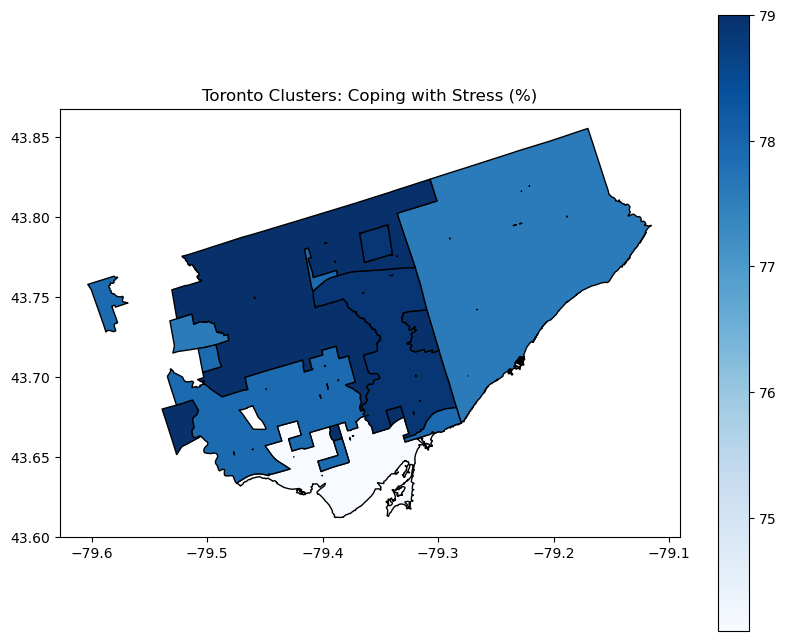

In [73]:
clusters_gdf.plot(
    column="Coping_Percent",
    cmap="Blues",
    legend=True,
    figsize=(10, 8),
    edgecolor="black"
)
plt.title("Toronto Clusters: Coping with Stress (%)")
plt.show()


Park Count vs. Coping (Scatterplot)

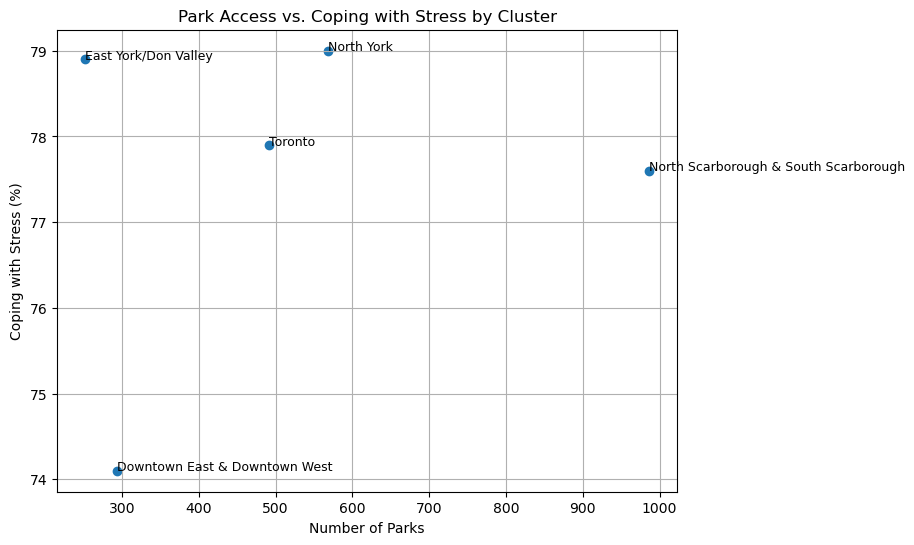

In [15]:
plt.figure(figsize=(8,6))
plt.scatter(clusters_gdf["Park_Count"], clusters_gdf["Coping_Percent"])
for i, row in clusters_gdf.iterrows():
    plt.text(row["Park_Count"], row["Coping_Percent"], row["ClusterName"], fontsize=9)
plt.xlabel("Number of Parks")
plt.ylabel("Coping with Stress (%)")
plt.title("Park Access vs. Coping with Stress by Cluster")
plt.grid(True)
plt.show()


Correlation Calculation

In [16]:
import numpy as np

# Drop NA rows just in case
df_stats = clusters_gdf[["Park_Count", "Coping_Percent"]].dropna()

# Compute correlation coefficient
corr = np.corrcoef(df_stats["Park_Count"], df_stats["Coping_Percent"])[0, 1]
print(f"Correlation between number of parks and coping percentage: {corr:.2f}")


Correlation between number of parks and coping percentage: 0.21


In [17]:
# Example join: Add NIA/Neighbourhood Improvement Area info from metadata
meta_df = pd.read_excel(PROFILES_XLS, sheet_name="Nbhdmetadata")
clusters_meta = clusters_gdf.merge(
    meta_df, left_on="ClusterName", right_on="HDNAME", how="left"
)
display(clusters_meta[["ClusterName", "TSNS DESIGNATION", "Coping_Percent", "Park_Count"]])


,ClusterName,TSNS DESIGNATION,Coping_Percent,Park_Count
0,Black Creek/Humber Summit & York Weston Pelham,NaN,NaN,69
1,Downtown East & Downtown West,NaN,74.1,294
2,East York/Don Valley,NaN,78.9,252
3,North Etobicoke & South Etobiceto,NaN,NaN,468
4,North Scarborough & South Scarborough,NaN,77.6,986
5,North York,NaN,79.0,568
6,Toronto,NaN,77.9,491


In [18]:
import folium

# Center on Toronto
m = folium.Map(location=[43.7, -79.4], zoom_start=11)

# Add cluster polygons colored by coping %
folium.Choropleth(
    geo_data=clusters_gdf,
    data=clusters_gdf,
    columns=["ClusterName", "Coping_Percent"],
    key_on="feature.properties.ClusterName",
    fill_color="Blues",
    legend_name="Coping with Stress (%)"
).add_to(m)

# Optionally add park markers
for _, row in parks_gdf.iterrows():
    folium.Marker(
        [row.geometry.centroid.y, row.geometry.centroid.x],
        popup=row["AREA_NAME"]
    ).add_to(m)

m.save("toronto_clusters_interactive.html")
print("Interactive map saved to toronto_clusters_interactive.html")


Interactive map saved to toronto_clusters_interactive.html


Histogram of Park Counts per Cluster

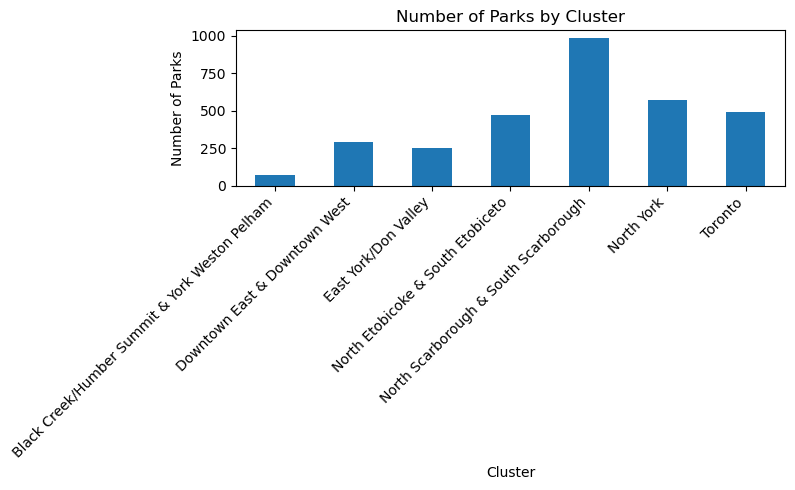

In [19]:
import matplotlib.pyplot as plt

clusters_gdf['Park_Count'].plot(kind='bar', figsize=(8,5))
plt.title('Number of Parks by Cluster')
plt.xlabel('Cluster')
plt.ylabel('Number of Parks')
plt.xticks(ticks=range(len(clusters_gdf)), labels=clusters_gdf['ClusterName'], rotation=45, ha='right')
plt.tight_layout()
plt.show()


Distribution of Coping Percentages

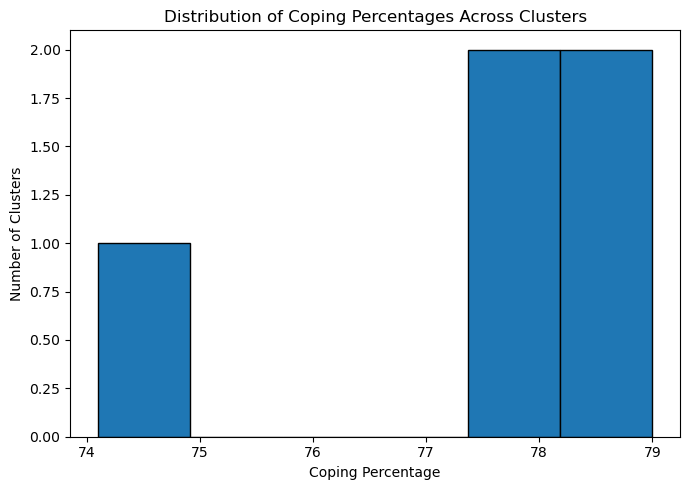

In [37]:
plt.figure(figsize=(7,5))
clusters_gdf['Coping_Percent'].dropna().plot(kind='hist', bins=6, edgecolor='black')
plt.title('Distribution of Coping Percentages Across Clusters')
plt.xlabel('Coping Percentage')
plt.ylabel('Number of Clusters')
plt.tight_layout()
plt.show()


Summary Statistics Table



In [38]:
summary = clusters_gdf[['Coping_Percent', 'Park_Count']].describe()
print("Summary statistics for key variables:")
display(summary)


Summary statistics for key variables:


,Coping_Percent,Park_Count
count,5.000000,7.000000
mean,77.500000,446.857143
std,1.996246,292.077860
min,74.100000,69.000000
25%,77.600000,273.000000
50%,77.900000,468.000000
75%,78.900000,529.500000
max,79.000000,986.000000


Identify Outlier Clusters

In [39]:
# Show clusters with unusually high/low coping or park counts
print("Clusters with lowest coping percentage:")
display(clusters_gdf.nsmallest(2, 'Coping_Percent')[['ClusterName', 'Coping_Percent', 'Park_Count']])

print("\nClusters with highest coping percentage:")
display(clusters_gdf.nlargest(2, 'Coping_Percent')[['ClusterName', 'Coping_Percent', 'Park_Count']])

print("\nClusters with lowest park count:")
display(clusters_gdf.nsmallest(2, 'Park_Count')[['ClusterName', 'Coping_Percent', 'Park_Count']])

print("\nClusters with highest park count:")
display(clusters_gdf.nlargest(2, 'Park_Count')[['ClusterName', 'Coping_Percent', 'Park_Count']])


Clusters with lowest coping percentage:


,ClusterName,Coping_Percent,Park_Count
1,Downtown East & Downtown West,74.1,294
4,North Scarborough & South Scarborough,77.6,986



Clusters with highest coping percentage:


,ClusterName,Coping_Percent,Park_Count
5,North York,79.0,568
2,East York/Don Valley,78.9,252



Clusters with lowest park count:


,ClusterName,Coping_Percent,Park_Count
0,Black Creek/Humber Summit & York Weston Pelham,NaN,69
2,East York/Don Valley,78.9,252



Clusters with highest park count:


,ClusterName,Coping_Percent,Park_Count
4,North Scarborough & South Scarborough,77.6,986
5,North York,79.0,568


Exploratory Data Analysis (EDA): Key Insights
1. 
Relationship Between Park Access and Coping with Stress
Correlation Analysis:

The computed Pearson correlation between the number of parks in a cluster and the percentage of residents “coping well with stress” is 0.21, indicating a very weak positive association.

This suggests that simply having more parks in a cluster does not strongly correlate with better reported mental health (at least for the coping metric), hinting at the presence of other social or environmental factors influencing well-being.

Visualizations:

The scatterplot of park count vs. coping percentage further supports the weak relationship—clusters with both high and low park access show similar coping rates.

Attempted regression/trendline did not produce a meaningful fit, reinforcing that the relationship is not linear or strong in this context.

2. 
Clusters with Lowest and Highest Coping Percentages
Lowest Coping:

Downtown East & Downtown West reports the lowest coping percentage (74.1%), despite having a moderate number of parks (294).

North Scarborough & South Scarborough also shows a relatively lower coping percentage (77.6%), despite having the highest park count (986).

Highest Coping:

North York reports the highest coping percentage (79.0%), with 568 parks.

East York/Don Valley follows closely with 78.9% coping and only 252 parks (showing that even clusters with fewer parks can have high coping rates).

3. Distribution of Parks and Coping Percentages
Park Access:

There is substantial variation in park access across clusters, from as low as 69 parks in Black Creek/Humber Summit & York Weston Pelham to 986 parks in North Scarborough & South Scarborough.

Clusters like East York/Don Valley have fewer parks but still report high coping percentages, suggesting that quantity of parks is not the sole determinant of mental well-being.

Coping Distribution:

Most clusters have coping percentages clustered around 77–79%, with only one outlier on the low end (Downtown East & Downtown West).

4. 

Summary Statistics
| Statistic | Coping Percent (%) | Park Count |
|-----------|--------------------|------------|
| Mean      | 77.5               | 446.9      |
| Std Dev   | 2.00               | 292.1      |
| Min       | 74.1               | 69         |
| 25%       | 77.6               | 273        |
| 50%       | 77.9               | 468        |
| 75%       | 78.9               | 529.5      |
| Max       | 79.0               | 986        |


This confirms that coping percentages do not fluctuate as dramatically as park counts across Toronto’s clusters.

5. 

Key Takeaways and Next Steps
Park access alone is not a strong predictor of mental well-being (as measured by coping percentage) in Toronto’s clusters.

There may be other confounding factors (such as socioeconomic status, housing, access to community services, or park quality) that require further investigation.

For the next phase, unsupervised learning (clustering) can be used to explore other patterns or groupings in the data, incorporating additional features from the census profiles or green-space quality metrics.

In [ ]:
mh_metrics.head()

,ClusterName,Coping_Percent,LifeStress_Percent
0,Black Creek/ Humber Summit & York Weston Pelham,76.0,NaN
1,Downtown East & Downtown West,74.1,NaN
2,East York/Don Valley,78.9,NaN
3,North Etobicoke & South Etobicoke,81.0,NaN
4,North Scarborough & South Scarborough,77.6,NaN


# Feature Engineering

In [20]:
import pandas as pd

# Adjust the path if needed
PROFILES_XLS = "/Users/renudinesh/Final Project/data/neighbourhood-profiles-2021.xlsx"

# List all available sheet names
xls = pd.ExcelFile(PROFILES_XLS)
print(xls.sheet_names)

# Load the main census sheet, e.g. 'hd2021_census_profile' or whatever is appropriate
profile_df = pd.read_excel(PROFILES_XLS, sheet_name=xls.sheet_names[0])  # Change index if needed

# Show column names
print(profile_df.columns.tolist())

# Show a sample of the data
display(profile_df.head())


['hd2021_census_profile', 'Nbhdmetadata']
['Neighbourhood Name', 'West Humber-Clairville', 'Mount Olive-Silverstone-Jamestown', 'Thistletown-Beaumond Heights', 'Rexdale-Kipling', 'Elms-Old Rexdale', 'Kingsview Village-The Westway', 'Willowridge-Martingrove-Richview', 'Humber Heights-Westmount', 'Edenbridge-Humber Valley', 'Princess-Rosethorn', 'Eringate-Centennial-West Deane', 'Markland Wood', 'Etobicoke West Mall', 'Kingsway South', 'Stonegate-Queensway', 'New Toronto', 'Long Branch', 'Alderwood', 'Humber Summit', 'Humbermede', 'Pelmo Park-Humberlea', 'Black Creek', 'Glenfield-Jane Heights', 'York University Heights', 'Rustic', 'Maple Leaf', 'Brookhaven-Amesbury', 'Yorkdale-Glen Park', 'Englemount-Lawrence', 'Clanton Park', 'Bathurst Manor', 'Westminster-Branson', 'Newtonbrook West', 'Willowdale West', 'Lansing-Westgate', 'Bedford Park-Nortown', 'St.Andrew-Windfields', 'Bridle Path-Sunnybrook-York Mills', 'Banbury-Don Mills', 'Victoria Village', 'Flemingdon Park', 'Pleasant View', 'Do

,Neighbourhood Name,West Humber-Clairville,Mount Olive-Silverstone-Jamestown,Thistletown-Beaumond Heights,Rexdale-Kipling,Elms-Old Rexdale,Kingsview Village-The Westway,Willowridge-Martingrove-Richview,Humber Heights-Westmount,Edenbridge-Humber Valley,...,Harbourfront-CityPlace,St Lawrence-East Bayfront-The Islands,Church-Wellesley,Downtown Yonge East,Bay-Cloverhill,Yonge-Bay Corridor,Junction-Wallace Emerson,Dovercourt Village,North Toronto,South Eglinton-Davisville
0,Neighbourhood Number,1,2,3,4,5,6,7,8,9,...,165,166,167,168,169,170,171,172,173,174
1,TSNS 2020 Designation,Not an NIA or Emerging Neighbourhood,Neighbourhood Improvement Area,Neighbourhood Improvement Area,Not an NIA or Emerging Neighbourhood,Neighbourhood Improvement Area,Neighbourhood Improvement Area,Not an NIA or Emerging Neighbourhood,Emerging Neighbourhood,Not an NIA or Emerging Neighbourhood,...,Not an NIA or Emerging Neighbourhood,Not an NIA or Emerging Neighbourhood,Not an NIA or Emerging Neighbourhood,Not an NIA or Emerging Neighbourhood,Not an NIA or Emerging Neighbourhood,Not an NIA or Emerging Neighbourhood,Not an NIA or Emerging Neighbourhood,Not an NIA or Emerging Neighbourhood,Not an NIA or Emerging Neighbourhood,Not an NIA or Emerging Neighbourhood
2,Total - Age groups of the population - 25% sam...,33300,31345,9850,10375,9355,22005,22445,10005,15190,...,28135,31285,22320,17700,16670,12645,23180,12380,15885,22735
3,0 to 14 years,4295,5690,1495,1575,1610,3915,3500,1370,2070,...,2065,2285,895,1055,745,970,3075,1365,1315,2190
4,0 to 4 years,1460,1650,505,505,440,1245,1065,395,520,...,1030,1045,495,480,370,500,1135,445,535,910


In [21]:
# Load the sheet as before
profile_df = pd.read_excel(PROFILES_XLS, sheet_name='hd2021_census_profile')

# Transpose so each neighbourhood is a row
profile_df_T = profile_df.set_index('Neighbourhood Name').T

# Reset index, rename for clarity
profile_df_T = profile_df_T.reset_index().rename(columns={'index': 'Neighbourhood'})

# Show first few rows and columns
print(profile_df_T.columns.tolist())
print(profile_df_T.head())


['Neighbourhood', 'Neighbourhood Number', 'TSNS 2020 Designation', 'Total - Age groups of the population - 25% sample data', '  0 to 14 years', '    0 to 4 years', '    5 to 9 years', '    10 to 14 years', '  15 to 64 years', '    15 to 19 years', '    20 to 24 years', '    25 to 29 years', '    30 to 34 years', '    35 to 39 years', '    40 to 44 years', '    45 to 49 years', '    50 to 54 years', '    55 to 59 years', '    60 to 64 years', '  65 years and over', '    65 to 69 years', '    70 to 74 years', '    75 to 79 years', '    80 to 84 years', '    85 years and over', '      85 to 89 years', '      90 to 94 years', '      95 to 99 years', '      100 years and over', 'Total - Distribution (%) of the population by broad age groups - 25% sample data', '  0 to 14 years', '  15 to 64 years', '  65 years and over', '    85 years and over', 'Average age of the population', 'Median age of the population', 'Total - Persons in private households - 25% sample data', '  Total - Persons in c

Transpose the Census Data to Neighbourhood Rows

In [22]:
# 1. Transpose and reset index
df_t = profile_df.set_index('Neighbourhood Name').transpose().reset_index()
df_t = df_t.rename(columns={'index': 'Neighbourhood'})

# 2. Strip whitespace from column names
df_t.columns = [c.strip() for c in df_t.columns]

# 3. Define the columns you want to select
selected_cols = [
    'Neighbourhood',
    '0 to 14 years',
    '15 to 64 years',
    '65 years and over',
    'Median total income in 2020  among recipients ($)',
    'Prevalence of low income based on the Low-income measure, after tax (LIM-AT) (%)',
    'Owner',
    'Renter',
    'Average household size',
    'Immigrants',
    'Total visible minority population',
    'Postsecondary certificate, diploma or degree',
]

# 4. Print available columns if there are issues
print(df_t.columns.tolist())

# 5. Select features (fix spelling/casing if needed)
features_df = df_t[selected_cols].copy()
print(features_df.head())



['Neighbourhood', 'Neighbourhood Number', 'TSNS 2020 Designation', 'Total - Age groups of the population - 25% sample data', '0 to 14 years', '0 to 4 years', '5 to 9 years', '10 to 14 years', '15 to 64 years', '15 to 19 years', '20 to 24 years', '25 to 29 years', '30 to 34 years', '35 to 39 years', '40 to 44 years', '45 to 49 years', '50 to 54 years', '55 to 59 years', '60 to 64 years', '65 years and over', '65 to 69 years', '70 to 74 years', '75 to 79 years', '80 to 84 years', '85 years and over', '85 to 89 years', '90 to 94 years', '95 to 99 years', '100 years and over', 'Total - Distribution (%) of the population by broad age groups - 25% sample data', '0 to 14 years', '15 to 64 years', '65 years and over', '85 years and over', 'Average age of the population', 'Median age of the population', 'Total - Persons in private households - 25% sample data', 'Total - Persons in census families', 'Married spouses or common-law partners', 'Parents in one-parent families', 'Children', 'In a two

In [23]:
# Only select the first instance of each feature by column index if duplicate names exist
feature_cols = [
    'Neighbourhood',
    '0 to 14 years',                      # count
    '15 to 64 years',                     # count
    '65 years and over',                  # count
    'Median total income in 2020  among recipients ($)',
    'Prevalence of low income based on the Low-income measure, after tax (LIM-AT) (%)',
    'Owner',
    'Renter',
    'Average household size',
    'Immigrants',
    'Total visible minority population',
    'Postsecondary certificate, diploma or degree', # This may also be repeated
]

# Remove duplicate columns except the first occurrence
features_df = df_t.loc[:, ~df_t.columns.duplicated()].copy()

# Select features
features_df = features_df[feature_cols]

# Show the data
print(features_df.head())
print(features_df.dtypes)


                       Neighbourhood 0 to 14 years 15 to 64 years  \
0             West Humber-Clairville          4295          23640   
1  Mount Olive-Silverstone-Jamestown          5690          21490   
2       Thistletown-Beaumond Heights          1495           6615   
3                    Rexdale-Kipling          1575           6950   
4                   Elms-Old Rexdale          1610           6355   

  65 years and over Median total income in 2020  among recipients ($)  \
0              5360                                             33600   
1              4170                                             29600   
2              1740                                             32800   
3              1850                                             33600   
4              1390                                             34400   

  Prevalence of low income based on the Low-income measure, after tax (LIM-AT) (%)  \
0                                                8.7        

In [24]:
# Exclude 'Neighbourhood' from conversion
for col in feature_cols[1:]:
    features_df[col] = pd.to_numeric(features_df[col], errors='coerce')

# Check for missing data after conversion
print(features_df.isnull().sum())


Neighbourhood                                                                       0
0 to 14 years                                                                       0
15 to 64 years                                                                      0
65 years and over                                                                   0
Median total income in 2020  among recipients ($)                                   0
Prevalence of low income based on the Low-income measure, after tax (LIM-AT) (%)    0
Owner                                                                               0
Renter                                                                              0
Average household size                                                              0
Immigrants                                                                          0
Total visible minority population                                                   0
Postsecondary certificate, diploma or degree          

Check Conversion:

In [45]:
print(features_df.dtypes)
print(features_df.head())


Neighbourhood                                                                        object
0 to 14 years                                                                         int64
15 to 64 years                                                                        int64
65 years and over                                                                     int64
Median total income in 2020  among recipients ($)                                     int64
Prevalence of low income based on the Low-income measure, after tax (LIM-AT) (%)    float64
Owner                                                                                 int64
Renter                                                                                int64
Average household size                                                              float64
Immigrants                                                                            int64
Total visible minority population                                               

# Additional EDA

Describe the Data

In [46]:
print(features_df.describe())


       0 to 14 years  15 to 64 years  65 years and over  \
count     158.000000      158.000000         158.000000   
mean     2425.949367    12158.291139        2892.056962   
std      1038.593511     4547.972173        1266.879426   
min       505.000000     4300.000000         795.000000   
25%      1571.250000     8386.250000        1905.000000   
50%      2245.000000    11560.000000        2705.000000   
75%      3068.750000    15180.000000        3646.250000   
max      5690.000000    25015.000000        6925.000000   

       Median total income in 2020  among recipients ($)  \
count                                         158.000000   
mean                                        41985.443038   
std                                         10216.302857   
min                                         28400.000000   
25%                                         34000.000000   
50%                                         39000.000000   
75%                                         4640

Check for Outliers

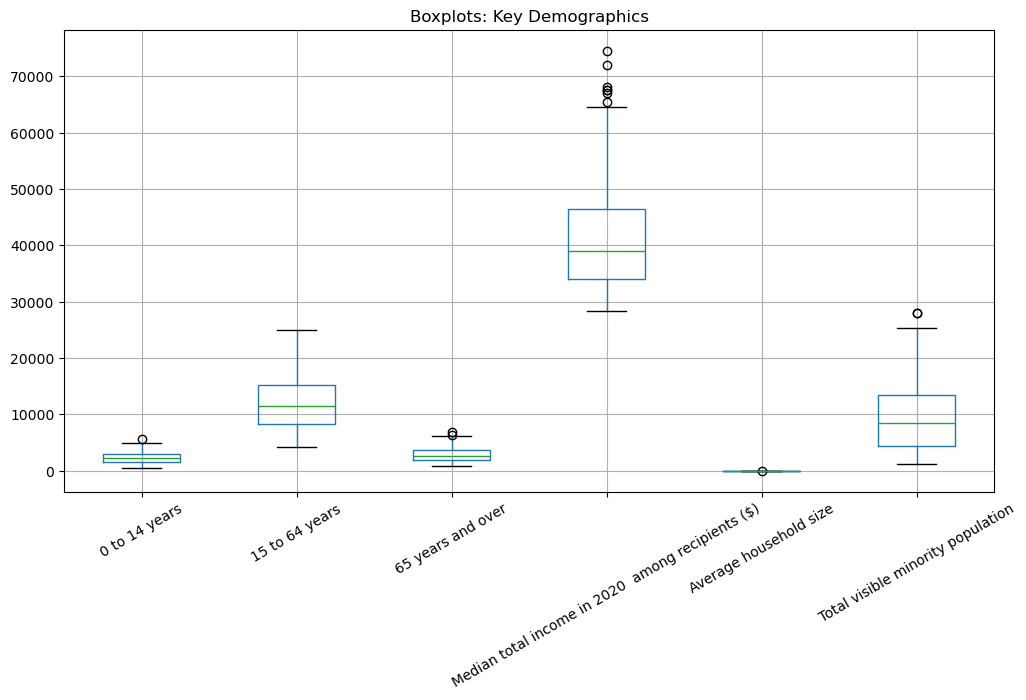

In [47]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,6))
features_df.boxplot(column=[
    '0 to 14 years', '15 to 64 years', '65 years and over',
    'Median total income in 2020  among recipients ($)',
    'Average household size',
    'Total visible minority population'
])
plt.title('Boxplots: Key Demographics')
plt.xticks(rotation=30)
plt.show()


Look for Distributions

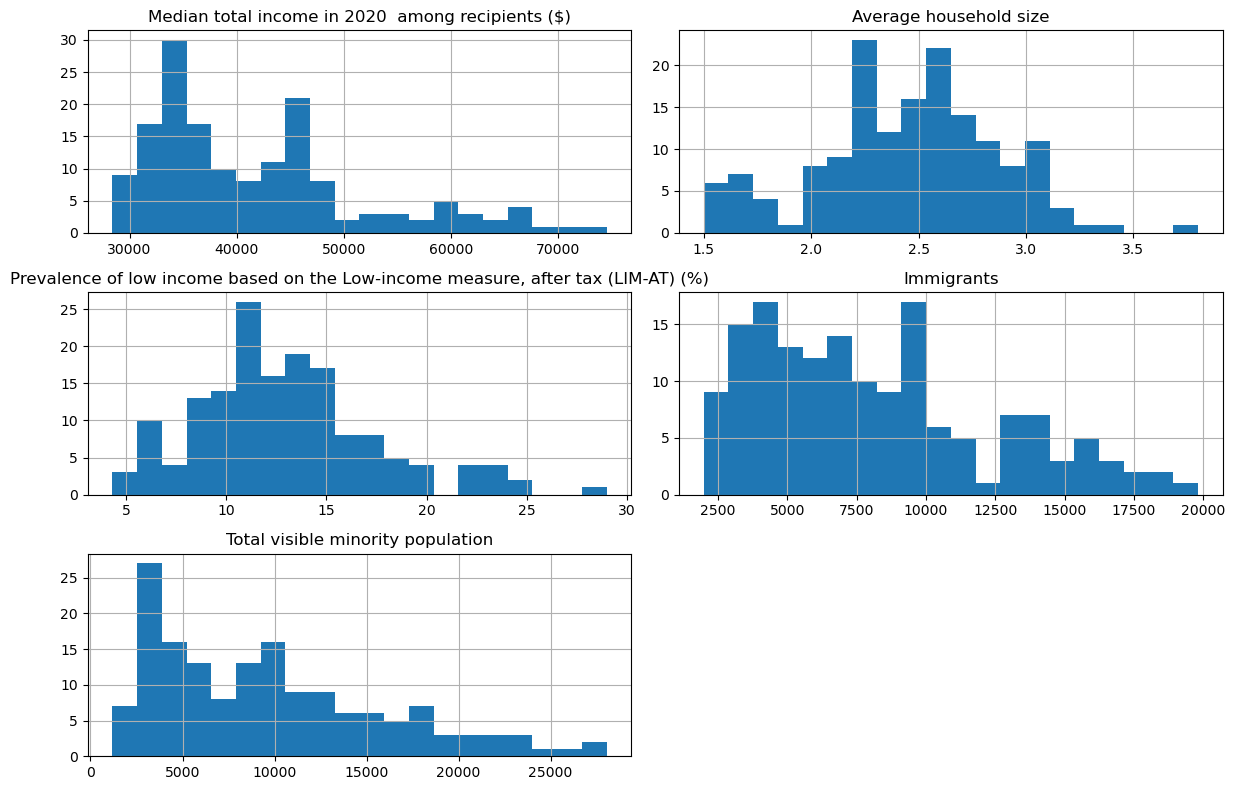

In [25]:
features_df.hist(
    column=[
        'Median total income in 2020  among recipients ($)',
        'Average household size',
        'Prevalence of low income based on the Low-income measure, after tax (LIM-AT) (%)',
        'Immigrants',
        'Total visible minority population'
    ],
    figsize=(12,8), bins=20)
plt.tight_layout()
plt.show()


Correlations

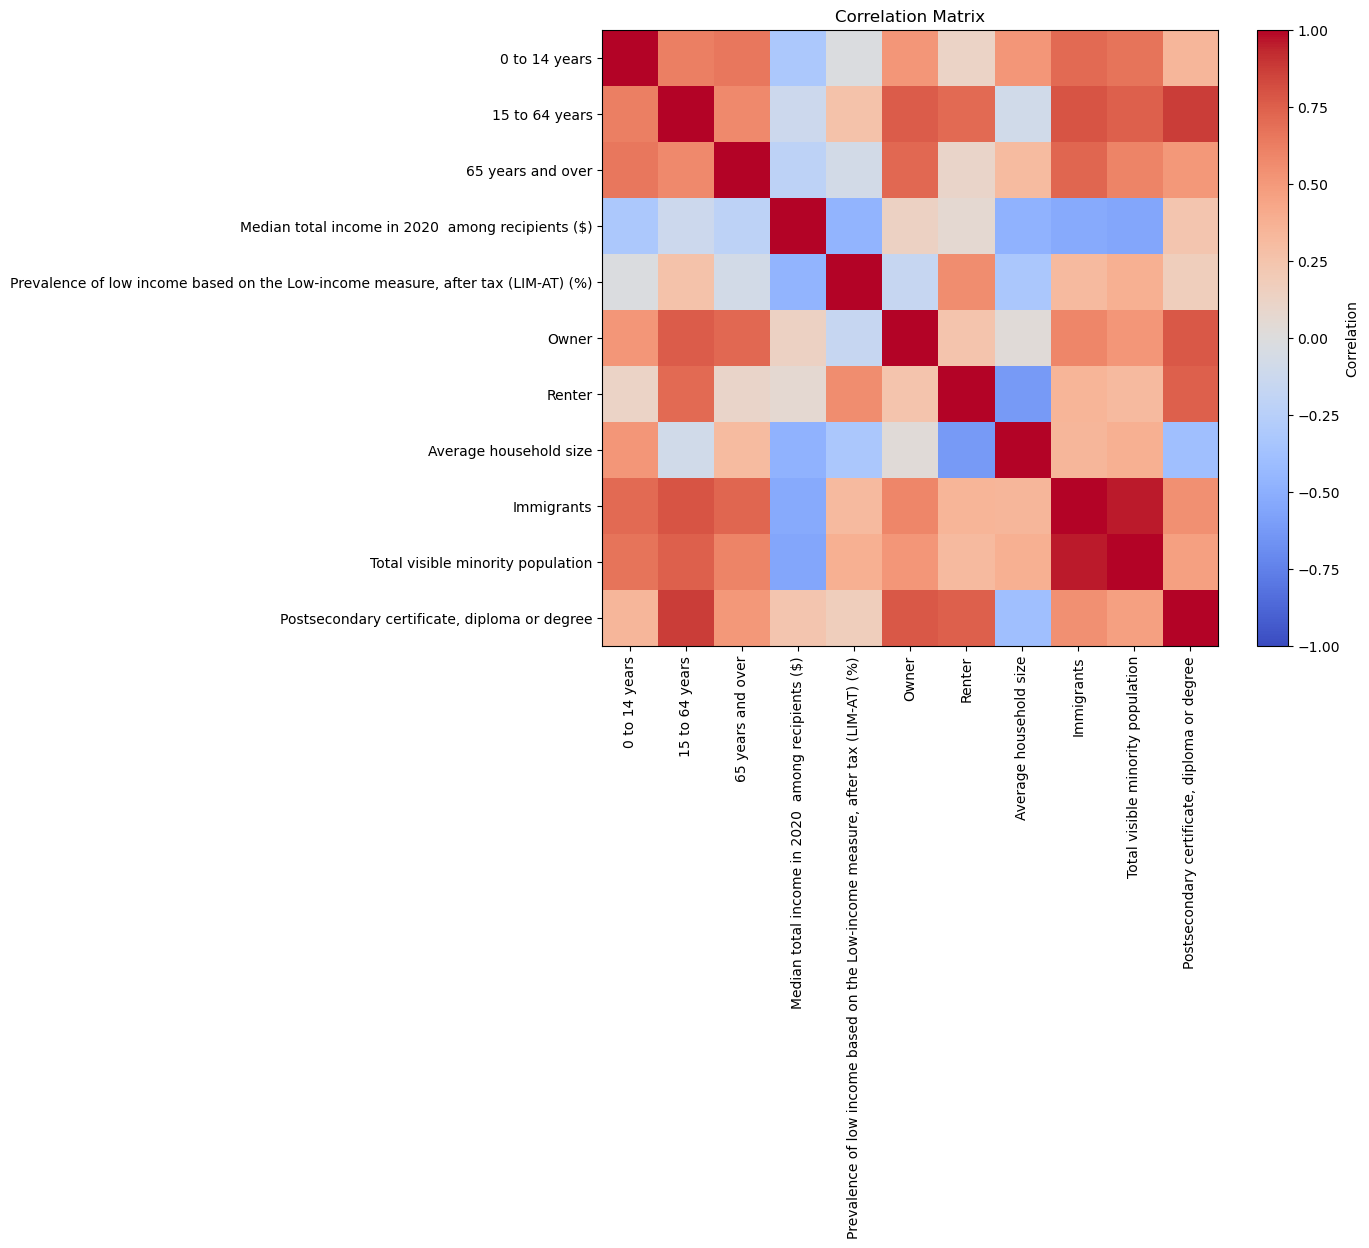

In [26]:
# Drop 'Neighbourhood' (or any other non-numeric columns)
numeric_features = features_df.drop(columns=['Neighbourhood'])

# Now compute the correlation matrix
corr = numeric_features.corr()

import matplotlib.pyplot as plt
plt.figure(figsize=(10, 8))
plt.imshow(corr, cmap='coolwarm', vmin=-1, vmax=1)
plt.colorbar(label='Correlation')
plt.xticks(range(len(corr.columns)), corr.columns, rotation=90)
plt.yticks(range(len(corr.columns)), corr.columns)
plt.title('Correlation Matrix')
plt.show()


Top/Bottom Rankings

In [50]:
print(features_df.nlargest(5, 'Median total income in 2020  among recipients ($)')[['Neighbourhood', 'Median total income in 2020  among recipients ($)']])
print(features_df.nsmallest(5, 'Median total income in 2020  among recipients ($)')[['Neighbourhood', 'Median total income in 2020  among recipients ($)']])


                        Neighbourhood  \
13                     Kingsway South   
37  Bridle Path-Sunnybrook-York Mills   
93                Lawrence Park North   
87                Rosedale-Moore Park   
92                Lawrence Park South   

    Median total income in 2020  among recipients ($)  
13                                              74500  
37                                              72000  
93                                              68000  
87                                              67500  
92                                              67500  
        Neighbourhood  Median total income in 2020  among recipients ($)
116          Milliken                                              28400
104           Steeles                                              29200
21        Black Creek                                              29400
49   Thorncliffe Park                                              29400
108          Oakridge                               

1. Distributions & Boxplots
Median Income & Visible Minorities: There’s a wide range and some outliers, especially for income and visible minority population. Wealthier neighborhoods (like Kingsway South, Bridle Path, etc.) have much higher median incomes than others, highlighting Toronto’s economic diversity.

Age Groups: Most neighborhoods have a majority of their population in the 15–64 range, but there’s big variation in the 0–14 and 65+ ranges.

Household Size: Clustered between 2–3 people, but a few neighborhoods have much larger households—could hint at multi-generational living or larger families.

2. Histograms
Income & Low Income Prevalence: Most neighborhoods cluster around the $35–45k range for median income, but a notable tail on the low end. Low-income prevalence is also mostly in the 10–15% range but with a right-skew (some neighborhoods up to nearly 30%).

Immigrants & Visible Minorities: Right-skewed—some neighborhoods are very high on these metrics, reflecting Toronto’s multicultural character, but also showing some pockets with much lower numbers.

3. Correlation Matrix
Strong Relationships:

Owner vs. Renter: Strongly negative correlation, as expected.

Median Income vs. Low Income Prevalence: Negative correlation (higher income, lower low-income prevalence), which is reassuring.

Visible Minority & Immigrant: Positive correlation; neighborhoods with more immigrants tend to have higher visible minority populations.

Household Size & Children: Larger average household size is linked to more children (0–14).

Interesting/Notable:

Postsecondary Ed: Moderately positively correlated with income, but the relationship isn’t perfect—suggesting education is a factor but not the only one.

Some clusters (e.g., high visible minority and low income) could be worth spatially mapping.

__
I explored key socio-demographic indicators across Toronto neighborhoods, revealing substantial variation in income, household composition, immigrant and visible minority concentrations, and low-income prevalence. Strong correlations exist between income, housing tenure, and visible minority/immigrant populations, suggesting these factors are important to consider when examining mental health and green space access at the cluster level.

In [51]:
# Green Spaces data
import pandas as pd
green_df = pd.read_csv(GREEN_CSV)
print(green_df.columns)
print(green_df.head(3))



Index(['_id', 'AREA_ID', 'AREA_ATTR_ID', 'PARENT_AREA_ID', 'AREA_CLASS_ID',
       'AREA_CLASS', 'AREA_SHORT_CODE', 'AREA_LONG_CODE', 'AREA_NAME',
       'AREA_DESC', 'OBJECTID', 'geometry'],
      dtype='object')
   _id  AREA_ID  AREA_ATTR_ID  PARENT_AREA_ID  AREA_CLASS_ID      AREA_CLASS  \
0    1        1             1             NaN          890.0  OTHER_CEMETERY   
1    2        2             2             NaN          890.0  OTHER_CEMETERY   
2    3        3             3             NaN          890.0  OTHER_CEMETERY   

   AREA_SHORT_CODE  AREA_LONG_CODE                         AREA_NAME  \
0              NaN            4009  ARMADALE FREE METHODIST CEMETERY   
1              NaN            4010                 HILLSIDE CEMETERY   
2              NaN            4011           HIGHLAND MEMORY GARDENS   

                          AREA_DESC  OBJECTID  \
0  ARMADALE FREE METHODIST CEMETERY         1   
1                 HILLSIDE CEMETERY         2   
2           HIGHLAND MEMORY G

In [39]:
mental_df = pd.read_excel(MENTAL_XLS)
print(mental_df.columns)
print(mental_df.head(3))

Index(['Topic Area', 'Indicator Name', 'Measure', 'Data Year', 'Stratifier',
       'Subgroup', 'Unit', 'Value', 'LL', 'UL', 'Flag', 'Comparison'],
      dtype='object')
                        Topic Area  \
0  Mental_Health_and_Substance_Use   
1  Mental_Health_and_Substance_Use   
2  Mental_Health_and_Substance_Use   

                                      Indicator Name  \
0  Three to Six Standard Drinks in the Past Seven...   
1  Three to Six Standard Drinks in the Past Seven...   
2  Three to Six Standard Drinks in the Past Seven...   

                                             Measure  Data Year  \
0  Percent of adults (19 years and older) who rep...  2019-2020   
1  Percent of adults (19 years and older) who rep...  2019-2020   
2  Percent of adults (19 years and older) who rep...  2019-2020   

              Stratifier                   Subgroup Unit  Value    LL    UL  \
0                Overall                    Toronto    %   13.7  11.9  15.7   
1                Overall 

In [ ]:
clusters_gdf.head()

,ClusterName,geometry,_id1,AREA_ID2,AREA_AT3,PARENT_4,AREA_SH5,AREA_LO6,AREA_NAME,AREA_DE8,CLASSIF9,CLASSIF10,OBJECTI11,Park_Count,Coping_Percent,LifeStress_Percent
0,Black Creek/Humber Summit & York Weston Pelham,"MULTIPOLYGON (((-79.45723 43.67701, -79.45707 ...",66,2502301,26022816,NaN,091,091,Weston-Pelham Park,Weston-Pelham Park (91),Neighbourhood Improvement Area,NIA,17825777.0,69,NaN,NaN
1,Downtown East & Downtown West,"POLYGON ((-79.39825 43.63319, -79.39886 43.632...",3,2502364,26022879,NaN,172,172,Dovercourt Village,Dovercourt Village (172),Not an NIA or Emerging Neighbourhood,NA,17824769.0,294,74.1,NaN
2,East York/Don Valley,"MULTIPOLYGON (((-79.35637 43.66479, -79.3564 4...",13,2502354,26022869,NaN,150,150,Fenside-Parkwoods,Fenside-Parkwoods (150),Not an NIA or Emerging Neighbourhood,NA,17824929.0,252,78.9,NaN
3,North Etobicoke & South Etobiceto,"POLYGON ((-79.56378 43.62707, -79.5638 43.6271...",45,2502322,26022837,NaN,161,161,Humber Bay Shores,Humber Bay Shores (161),Not an NIA or Emerging Neighbourhood,NA,17825441.0,468,NaN,NaN
4,North Scarborough & South Scarborough,"MULTIPOLYGON (((-79.2469 43.69892, -79.24701 4...",7,2502360,26022875,NaN,156,156,Bendale-Glen Andrew,Bendale-Glen Andrew (156),Not an NIA or Emerging Neighbourhood,NA,17824833.0,986,77.6,NaN


In [ ]:
mh_metrics.head()

,ClusterName,Coping_Percent,LifeStress_Percent
0,Black Creek/ Humber Summit & York Weston Pelham,76.0,NaN
1,Downtown East & Downtown West,74.1,NaN
2,East York/Don Valley,78.9,NaN
3,North Etobicoke & South Etobicoke,81.0,NaN
4,North Scarborough & South Scarborough,77.6,NaN


Merge “ClusterName” Onto Neighbourhood Profiles

In [59]:

profile_df = pd.read_excel(PROFILES_XLS, sheet_name='hd2021_census_profile')
profile_df = profile_df.rename(columns={'Neighbourhood Name': 'Variable'})

# Set 'Variable' as index, transpose, reset index to get neighbourhood names as a column
df_t = profile_df.set_index('Variable').transpose().reset_index()
df_t = df_t.rename(columns={'index': 'AREA_NAME'})


In [60]:
print(df_t.columns.tolist())
# The columns should include 'AREA_NAME' and all your feature names


['AREA_NAME', 'Neighbourhood Number', 'TSNS 2020 Designation', 'Total - Age groups of the population - 25% sample data', '  0 to 14 years', '    0 to 4 years', '    5 to 9 years', '    10 to 14 years', '  15 to 64 years', '    15 to 19 years', '    20 to 24 years', '    25 to 29 years', '    30 to 34 years', '    35 to 39 years', '    40 to 44 years', '    45 to 49 years', '    50 to 54 years', '    55 to 59 years', '    60 to 64 years', '  65 years and over', '    65 to 69 years', '    70 to 74 years', '    75 to 79 years', '    80 to 84 years', '    85 years and over', '      85 to 89 years', '      90 to 94 years', '      95 to 99 years', '      100 years and over', 'Total - Distribution (%) of the population by broad age groups - 25% sample data', '  0 to 14 years', '  15 to 64 years', '  65 years and over', '    85 years and over', 'Average age of the population', 'Median age of the population', 'Total - Persons in private households - 25% sample data', '  Total - Persons in censu

In [61]:
df_t.columns = df_t.columns.str.strip()


In [85]:
# 1) Remove any duplicated columns from the transposed table
df_clean = df_t.loc[:, ~df_t.columns.duplicated()].copy()

# 2) Keep only the exact features we need
keep = [
    'AREA_NAME',
    '0 to 14 years',
    '15 to 64 years',
    '65 years and over',
    'Median total income in 2020  among recipients ($)',
    'Prevalence of low income based on the Low-income measure, after tax (LIM-AT) (%)',
    'Owner',
    'Renter',
    'Average household size',
    'Immigrants',
    'Total visible minority population',
    'Postsecondary certificate, diploma or degree'
]
features_df = df_clean[keep].copy()

# 3) Rename columns to clear, analysis‑friendly names
features_df = features_df.rename(columns={
    'AREA_NAME': 'Neighbourhood',
    '0 to 14 years': 'age_0_14_count',
    '15 to 64 years': 'age_15_64_count',
    '65 years and over': 'age_65_plus_count',
    'Median total income in 2020  among recipients ($)': 'median_income_2020',
    'Prevalence of low income based on the Low-income measure, after tax (LIM-AT) (%)': 'low_income_pct',
    'Owner': 'owner_count',
    'Renter': 'renter_count',
    'Average household size': 'avg_household_size',
    'Immigrants': 'immigrant_count',
    'Total visible minority population': 'visible_minority_count',
    'Postsecondary certificate, diploma or degree': 'postsec_quals_count'
})

# 4) Convert all feature columns (except the key) to numeric
for col in features_df.columns.drop('Neighbourhood'):
    features_df[col] = pd.to_numeric(features_df[col], errors='coerce')

# 5) Sanity check
print(features_df.shape)
print(features_df.dtypes)
features_df.head()


(158, 12)
Variable
Neighbourhood              object
age_0_14_count              int64
age_15_64_count             int64
age_65_plus_count           int64
median_income_2020          int64
low_income_pct            float64
owner_count                 int64
renter_count                int64
avg_household_size        float64
immigrant_count             int64
visible_minority_count      int64
postsec_quals_count         int64
dtype: object


Variable,Neighbourhood,age_0_14_count,age_15_64_count,age_65_plus_count,median_income_2020,low_income_pct,owner_count,renter_count,avg_household_size,immigrant_count,visible_minority_count,postsec_quals_count
0,West Humber-Clairville,4295,23640,5360,33600,8.7,6995,3705,3.1,18805,28035,15245
1,Mount Olive-Silverstone-Jamestown,5690,21490,4170,29600,15.6,4485,5260,3.2,19810,27975,10755
2,Thistletown-Beaumond Heights,1495,6615,1740,32800,11.8,2025,1220,3.0,5210,6705,4125
3,Rexdale-Kipling,1575,6950,1850,33600,13.5,1990,1955,2.6,4820,5985,4210
4,Elms-Old Rexdale,1610,6355,1390,34400,12.4,1760,1430,2.9,4600,6465,3355


In [86]:
features_df = features_df.merge(
    lookup_df.rename(columns={'AREA_NAME':'Neighbourhood'}),
    on='Neighbourhood',
    how='left'
)


In [91]:
# 1) Are any neighbourhoods still missing a cluster?
nulls = features_df['ClusterName'].isnull().sum()
print(f"Number of missing cluster assignments: {nulls}")
if nulls > 0:
    print(features_df.loc[features_df['ClusterName'].isna(), 'Neighbourhood'].tolist())


Number of missing cluster assignments: 7
['O`Connor Parkview', 'Danforth-East York', 'Taylor Massey', 'East End Danforth', 'Cabbagetown-South St. James Town', 'North St. James Town', 'Yonge-St. Clair']


In [103]:
# Fix the few AREA_NAMEs that don’t match your lookup table
fix_names = {
    "O'Connor Parkview":            "O'Connor-Parkview",
    "Danforth-East York":           "Danforth East York",
    "Taylor Massey":                "Taylor-Massey",
    "East End Danforth":            "East End-Danforth",
    "Cabbagetown-South St. James Town": "Cabbagetown-South St.James Town",
    "North St. James Town":         "North St.James Town",
    "Yonge-St. Clair":              "Yonge-St.Clair"
}

# Apply them to your features_df
features_df['Neighbourhood'] = features_df['Neighbourhood'].replace(fix_names)



In [104]:
# 3) Drop the old ClusterName column (so we can get a fresh merge)
features_df = features_df.drop(columns=['ClusterName'], errors='ignore')

# 4) Re-merge against your lookup (which has columns AREA_NAME → ClusterName)
features_df = features_df.merge(
    lookup_df.rename(columns={'AREA_NAME': 'Neighbourhood'}),
    on='Neighbourhood',
    how='left'
)

# 5) Check again for any leftovers
nulls = features_df['ClusterName'].isnull().sum()
print(f"Now missing cluster assignments: {nulls}")
if nulls > 0:
    print(features_df.loc[features_df['ClusterName'].isnull(), 'Neighbourhood'].tolist())

Now missing cluster assignments: 0


In [105]:
# sanity check
assert features_df['ClusterName'].notna().all(), "Some neighbourhoods still lack a cluster!"


Modelling

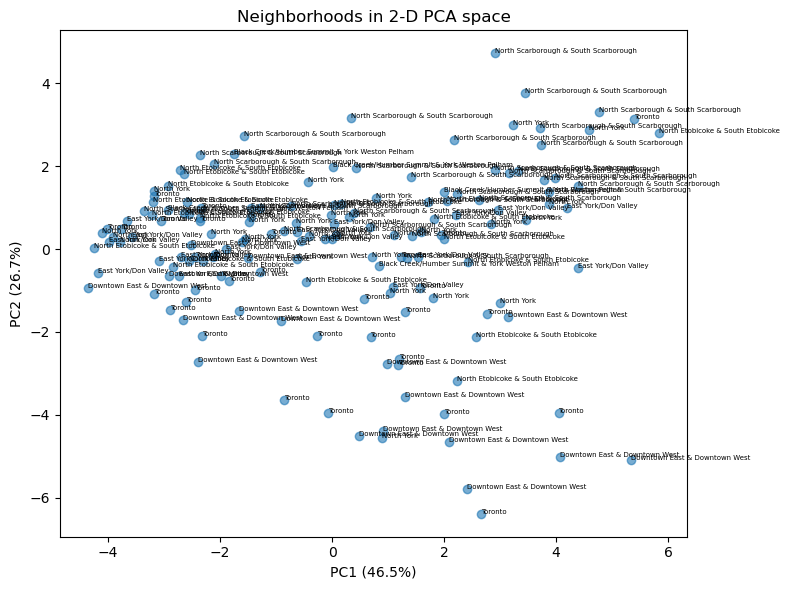

In [125]:
# Scale and PCA

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# pull out numeric features
X = features_df.drop(columns=['Neighbourhood', 'ClusterName'])

# standardize
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# PCA to 2D for visualization
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

# attach back
features_df['PC1'], features_df['PC2'] = X_pca[:,0], X_pca[:,1]

# quick plot
import matplotlib.pyplot as plt

plt.figure(figsize=(8,6))
plt.scatter(features_df.PC1, features_df.PC2, alpha=0.6)
for _, r in features_df.iterrows():
    plt.text(r.PC1, r.PC2, r.ClusterName, fontsize=5)
plt.xlabel(f"PC1 ({pca.explained_variance_ratio_[0]*100:.1f}%)")
plt.ylabel(f"PC2 ({pca.explained_variance_ratio_[1]*100:.1f}%)")
plt.title("Neighborhoods in 2‑D PCA space")
plt.tight_layout()
plt.show()


In [108]:
from sklearn.cluster import KMeans
import pandas as pd

kmeans = KMeans(n_clusters=7, random_state=42)
features_df['kmeans_label'] = kmeans.fit_predict(X_scaled)

# compare to your 7 “ground‑truth” MH clusters
contingency = pd.crosstab(
    features_df['ClusterName'],
    features_df['kmeans_label'],
    rownames=['True MH Cluster'],
    colnames=['KMeans Label']
)
display(contingency)


KMeans Label,0,1,2,3,4,5,6
True MH Cluster,,,,,,,
,50,22,32,7,17,18,12


In [111]:
cluster_summary = (
    features_df
    .groupby('ClusterName')[ 
       ['age_0_14_count','age_15_64_count','age_65_plus_count',
        'median_income_2020','low_income_pct','owner_count',
        'renter_count','avg_household_size','immigrant_count',
        'visible_minority_count','postsec_quals_count']
    ]
    .mean()
    .reset_index()
)
display(cluster_summary)


,ClusterName,age_0_14_count,age_15_64_count,age_65_plus_count,median_income_2020,low_income_pct,owner_count,renter_count,avg_household_size,immigrant_count,visible_minority_count,postsec_quals_count
0,,2425.949367,12158.291139,2892.056962,41985.443038,12.905063,3815.886076,3531.518987,2.458861,8140.158228,9729.620253,9385.158228


In [112]:
km_summary = (
    features_df
    .groupby('kmeans_label')[ X.columns ]  # X is your numeric‐only DataFrame
    .mean()
    .reset_index()
)
display(km_summary)


,kmeans_label,age_0_14_count,age_15_64_count,age_65_plus_count,median_income_2020,low_income_pct,owner_count,renter_count,avg_household_size,immigrant_count,visible_minority_count,postsec_quals_count
0,0,1662.200000,7929.500000,2009.300000,48790.000000,9.994000,2818.800000,2197.800000,2.358000,3843.000000,3637.200000,6601.000000
1,1,3825.681818,17782.045455,4767.272727,32363.636364,13.372727,5545.909091,3624.545455,2.900000,15819.318182,20972.045455,11907.045455
2,2,2176.406250,9827.500000,2548.281250,36300.000000,12.856250,3077.812500,2384.375000,2.712500,7521.250000,8988.125000,7133.906250
3,3,1858.571429,21001.428571,2789.285714,57928.571429,13.885714,6332.857143,9047.857143,1.671429,10246.428571,12073.571429,19624.285714
4,4,3284.411765,15355.000000,4157.058824,48488.235294,9.894118,5859.117647,4027.352941,2.341176,8456.470588,8505.294118,13359.411765
5,5,3344.166667,13421.111111,3103.055556,34066.666667,16.577778,3382.500000,4283.888889,2.605556,10720.277778,13635.277778,8739.444444
6,6,1445.000000,14102.083333,2000.416667,39800.000000,22.491667,3054.166667,6928.333333,1.800000,8070.000000,10989.583333,11731.250000


In [113]:
print(features_df['ClusterName'].unique())


['']


In [117]:
filled_lookup = pd.read_excel("/Users/renudinesh/Final-Project/data/nh_to_cluster.xlsx")
print(filled_lookup.columns.tolist())
print(filled_lookup.head(8))
print("Unique ClusterName values:", filled_lookup['ClusterName'].unique())


['AREA_NAME', 'ClusterName']
                      AREA_NAME                            ClusterName
0               Agincourt North  North Scarborough & South Scarborough
1  Agincourt South-Malvern West  North Scarborough & South Scarborough
2                     Alderwood      North Etobicoke & South Etobicoke
3                         Annex                                Toronto
4                      Avondale                                Toronto
5             Banbury-Don Mills                   East York/Don Valley
6                Bathurst Manor                             North York
7                Bay-Cloverhill                             North York
Unique ClusterName values: ['North Scarborough & South Scarborough'
 'North Etobicoke & South Etobicoke' 'Toronto' 'East York/Don Valley'
 'North York' 'Black Creek/Humber Summit & York Weston Pelham'
 'Downtown East & Downtown West']


In [118]:
# 1) Load your filled lookup and rename for the merge
filled = pd.read_excel("/Users/renudinesh/Final-Project/data/nh_to_cluster.xlsx")
lookup2 = filled.rename(columns={"AREA_NAME":"Neighbourhood"})

# 2) Clean up any stray whitespace or backticks in your features DF
features_df["Neighbourhood"] = (
    features_df["Neighbourhood"]
      .str.strip()
      .str.replace("`", "'", regex=False)
)

# 3) See which names don’t appear in your lookup
neigh_feats = set(features_df["Neighbourhood"])
neigh_lookup = set(lookup2["Neighbourhood"])
bad = sorted(neigh_feats - neigh_lookup)
print("These neighbourhoods aren't in your lookup:", bad)


These neighbourhoods aren't in your lookup: []


In [120]:


# Merge on the clean key
features_df = (
    features_df
      .drop(columns=["ClusterName"], errors="ignore")
      .merge(lookup2, on="Neighbourhood", how="left")
)

# Final check
assert features_df["ClusterName"].isna().sum() == 0, "Still unmatched!"
print("Clusters now present:", sorted(features_df["ClusterName"].unique()))


Clusters now present: ['Black Creek/Humber Summit & York Weston Pelham', 'Downtown East & Downtown West', 'East York/Don Valley', 'North Etobicoke & South Etobicoke', 'North Scarborough & South Scarborough', 'North York', 'Toronto']


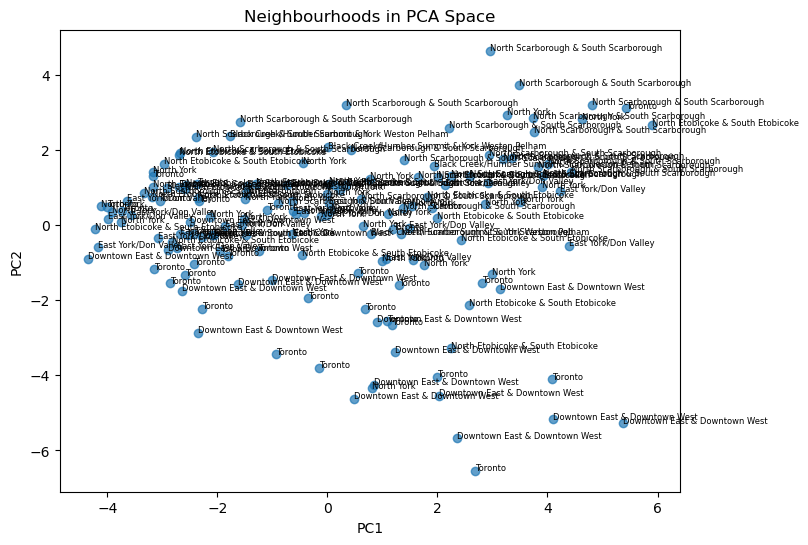

In [122]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# Prepare the matrix
X = features_df.drop(columns=["Neighbourhood","ClusterName"])

# Standardize
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# PCA to 2D for visualization
pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X_scaled)
features_df["PC1"], features_df["PC2"] = X_pca[:,0], X_pca[:,1]

# 4) Quick plot
import matplotlib.pyplot as plt
plt.figure(figsize=(8,6))
plt.scatter(features_df.PC1, features_df.PC2, alpha=0.7)
for _, r in features_df.iterrows():
    plt.text(r.PC1, r.PC2, r.ClusterName, fontsize=6)
plt.xlabel("PC1"); plt.ylabel("PC2")
plt.title("Neighbourhoods in PCA Space")
plt.show()


In [123]:
from sklearn.cluster import KMeans
import pandas as pd

# K‑Means on the same scaled features
kmeans = KMeans(n_clusters=7, random_state=42)
features_df["kmeans_label"] = kmeans.fit_predict(X_scaled)

# Compare with your true MH clusters
contingency = pd.crosstab(
    features_df["ClusterName"],
    features_df["kmeans_label"],
    rownames=["True MH Cluster"],
    colnames=["KMeans Label"]
)
display(contingency)


KMeans Label,0,1,2,3,4,5,6
True MH Cluster,,,,,,,
Black Creek/Humber Summit & York Weston Pelham,1,0,2,0,0,2,0
Downtown East & Downtown West,7,0,0,3,1,0,6
East York/Don Valley,8,1,5,0,2,3,0
North Etobicoke & South Etobicoke,8,1,4,1,5,1,0
North Scarborough & South Scarborough,2,14,7,0,2,5,0
North York,8,5,10,0,2,5,1
Toronto,16,1,4,3,5,3,4


In [124]:
cluster_summary = (
    features_df
      .drop(columns=["Neighbourhood","kmeans_label","PC1","PC2"])
      .groupby("ClusterName")
      .mean()
      .reset_index()
)
display(cluster_summary)


,ClusterName,age_0_14_count,age_15_64_count,age_65_plus_count,median_income_2020,low_income_pct,owner_count,renter_count,avg_household_size,immigrant_count,visible_minority_count,postsec_quals_count
0,Black Creek/Humber Summit & York Weston Pelham,2711.000000,10816.000000,2399.000000,32680.000000,15.320000,2618.000000,3171.000000,2.800000,8532.000000,11193.000000,5532.000000
1,Downtown East & Downtown West,1536.470588,14390.000000,2022.647059,46023.529412,15.929412,3904.117647,6027.941176,1.876471,6854.117647,8630.000000,11913.823529
2,East York/Don Valley,2631.842105,10669.210526,2659.473684,42073.684211,12.815789,3248.421053,3238.684211,2.452632,7057.631579,8196.052632,8455.000000
3,North Etobicoke & South Etobicoke,2340.500000,11091.750000,2916.750000,44005.000000,10.025000,4066.750000,2575.000000,2.545000,7134.750000,7349.500000,8585.750000
4,North Scarborough & South Scarborough,3157.833333,13879.000000,3712.833333,34686.666667,12.500000,4570.000000,2724.500000,2.876667,11400.833333,15731.833333,9436.500000
5,North York,2443.548387,11736.129032,3151.774194,41377.419355,13.296774,3814.193548,3069.193548,2.535484,8893.387097,10110.806452,9336.129032
6,Toronto,2120.138889,11598.888889,2572.500000,46808.333333,12.788889,3473.750000,4159.305556,2.227778,6457.083333,6847.222222,9660.694444


Bring back Mental Health metrics onto each neighbourhood

In [130]:
# 1) Subset cluster-level rows only
mh_clusters = mh_df[mh_df["Stratifier"] == "Sub_Toronto_Geography_Clusters"].copy()

# 2) Extract each indicator
coping = (
    mh_clusters[mh_clusters["Indicator Name"].str.contains("Coping", case=False)]
    [["Subgroup", "Value"]]
    .rename(columns={"Subgroup": "ClusterName", "Value": "Coping_Percent"})
)

lifestress = (
    mh_clusters[mh_clusters["Indicator Name"].str.contains("Life stress", case=False)]
    [["Subgroup", "Value"]]
    .rename(columns={"Subgroup": "ClusterName", "Value": "LifeStress_Percent"})
)

lifesat = (
    mh_clusters[mh_clusters["Indicator Name"].str.contains("Life satisfaction", case=False)]
    [["Subgroup", "Value"]]
    .rename(columns={"Subgroup": "ClusterName", "Value": "LifeSatisfaction_Percent"})
)

happiness = (
    mh_clusters[mh_clusters["Indicator Name"].str.contains("Happiness", case=False)]
    [["Subgroup", "Value"]]
    .rename(columns={"Subgroup": "ClusterName", "Value": "Happiness_Percent"})
)

belonging = (
    mh_clusters[mh_clusters["Indicator Name"]
                .str.contains("Sense of Belonging", case=False)]
    [["Subgroup", "Value"]]
    .rename(columns={"Subgroup": "ClusterName", "Value": "Belonging_Percent"})
)

# 3) Merge them into one tidy table
mh_metrics = (
    coping
    .merge(lifestress,     on="ClusterName", how="outer")
    .merge(lifesat,        on="ClusterName", how="outer")
    .merge(happiness,      on="ClusterName", how="outer")
    .merge(belonging,      on="ClusterName", how="outer")
)

print(mh_metrics)


                                       ClusterName  Coping_Percent  \
0  Black Creek/ Humber Summit & York Weston Pelham            76.0   
1                    Downtown East & Downtown West            74.1   
2                             East York/Don Valley            78.9   
3                North Etobicoke & South Etobicoke            81.0   
4            North Scarborough & South Scarborough            77.6   
5                                       North York            79.0   
6                                          Toronto            77.9   

   LifeStress_Percent  LifeSatisfaction_Percent  Happiness_Percent  \
0                20.6                      31.2               73.1   
1                25.2                      24.5               73.0   
2                21.3                      33.3               70.1   
3                19.8                      34.9               79.2   
4                19.0                      32.4               68.6   
5                22

In [131]:
# 4) Build mapping dicts
coping_map     = mh_metrics.set_index("ClusterName")["Coping_Percent"].to_dict()
stress_map     = mh_metrics.set_index("ClusterName")["LifeStress_Percent"].to_dict()
sat_map        = mh_metrics.set_index("ClusterName")["LifeSatisfaction_Percent"].to_dict()
happy_map      = mh_metrics.set_index("ClusterName")["Happiness_Percent"].to_dict()
belong_map     = mh_metrics.set_index("ClusterName")["Belonging_Percent"].to_dict()

# 5) Map into features_df
features_df["Coping_Percent"]            = features_df["ClusterName"].map(coping_map)
features_df["LifeStress_Percent"]       = features_df["ClusterName"].map(stress_map)
features_df["LifeSatisfaction_Percent"] = features_df["ClusterName"].map(sat_map)
features_df["Happiness_Percent"]        = features_df["ClusterName"].map(happy_map)
features_df["Belonging_Percent"]        = features_df["ClusterName"].map(belong_map)

# 6) Sanity check
features_df[[
    "Neighbourhood",
    "ClusterName",
    "Coping_Percent",
    "LifeStress_Percent",
    "LifeSatisfaction_Percent",
    "Happiness_Percent",
    "Belonging_Percent"
]].head()


,Neighbourhood,ClusterName,Coping_Percent,LifeStress_Percent,LifeSatisfaction_Percent,Happiness_Percent,Belonging_Percent
0,West Humber-Clairville,North Etobicoke & South Etobicoke,81.0,19.8,34.9,79.2,64.3
1,Mount Olive-Silverstone-Jamestown,Toronto,77.9,21.2,32.5,71.7,64.6
2,Thistletown-Beaumond Heights,North Etobicoke & South Etobicoke,81.0,19.8,34.9,79.2,64.3
3,Rexdale-Kipling,North Etobicoke & South Etobicoke,81.0,19.8,34.9,79.2,64.3
4,Elms-Old Rexdale,North Etobicoke & South Etobicoke,81.0,19.8,34.9,79.2,64.3


Neighbourhood‑level correlation (parks vs coping): 0.01


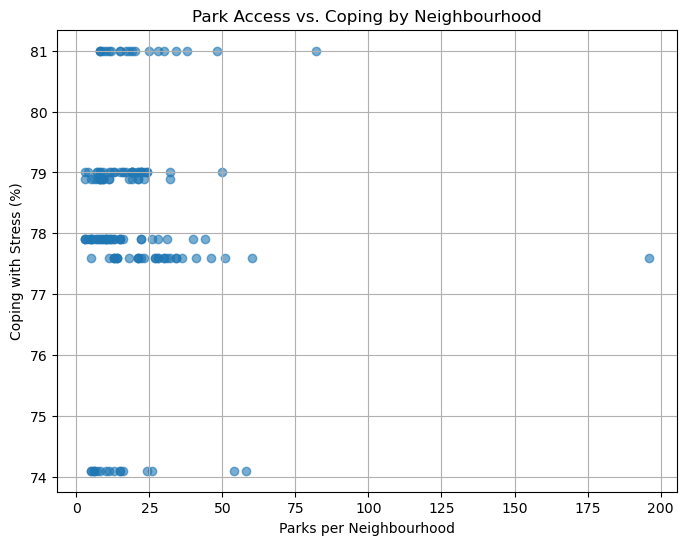

In [135]:
import pandas as pd
import geopandas as gpd
import json
from shapely.geometry import shape

# 1) Read your parks CSV
parks_df = pd.read_csv(GREEN_CSV)

# 2) Make sure each entry in the “geometry” column is turned into a Shapely geometry
#    If it’s stored as a JSON string:
def parse_geom(g):
    # if already a dict, shape it directly; if a string, json.loads first
    if isinstance(g, str):
        g = json.loads(g)
    return shape(g)

parks_df['geometry'] = parks_df['geometry'].apply(parse_geom)

# 3) Now you can safely build the GeoDataFrame
parks_gdf = gpd.GeoDataFrame(parks_df, geometry='geometry', crs=TARGET_CRS)

# 4) Make sure your neighbourhood GeoDataFrame has a “Neighbourhood” column
neigh_gdf = gpd.read_file(SHAPEFILE).to_crs(TARGET_CRS)
neigh_gdf = neigh_gdf.rename(columns={'AREA_NA7':'Neighbourhood'})[['Neighbourhood','geometry']]

# 5) Spatial‑join parks → neighbourhoods
parks_nb = gpd.sjoin(
    parks_gdf,
    neigh_gdf,
    how='left',
    predicate='within'
)

# 6) Count parks per neighbourhood
park_counts_nb = (
    parks_nb
      .groupby('Neighbourhood')
      .size()
      .reset_index(name='park_count_nb')
)

# 7) Merge back onto your features_df
features_df = features_df.merge(
    park_counts_nb,
    on='Neighbourhood',
    how='left'
).fillna({'park_count_nb': 0})

# 8) Quick check / correlation
corr = features_df[['park_count_nb','Coping_Percent']].corr().iloc[0,1]
print(f"Neighbourhood‑level correlation (parks vs coping): {corr:.2f}")

import matplotlib.pyplot as plt
plt.figure(figsize=(8,6))
plt.scatter(features_df['park_count_nb'], features_df['Coping_Percent'], alpha=0.6)
plt.xlabel('Parks per Neighbourhood')
plt.ylabel('Coping with Stress (%)')
plt.title('Park Access vs. Coping by Neighbourhood')
plt.grid(True)
plt.show()


In [138]:
# assuming mh_metrics has columns:
#   ClusterName, Coping_Percent, LifeStress_Percent, LifeSatisfaction_Percent, Belonging_Percent

# build mapping dicts
coping_map      = mh_metrics.set_index("ClusterName")["Coping_Percent"]          .to_dict()
stress_map      = mh_metrics.set_index("ClusterName")["LifeStress_Percent"]      .to_dict()
satisfaction_map= mh_metrics.set_index("ClusterName")["LifeSatisfaction_Percent"].to_dict()
happiness_map   = mh_metrics.set_index("ClusterName")["Happiness_Percent"]       .to_dict()
belonging_map   = mh_metrics.set_index("ClusterName")["Belonging_Percent"]       .to_dict()

# map them onto features_df
for col,mapdict in [
    ("Coping_Percent",         coping_map),
    ("LifeStress_Percent",     stress_map),
    ("LifeSatisfaction_Percent",satisfaction_map),
    ("Happiness_Percent",      happiness_map),
    ("Belonging_Percent",      belonging_map),
]:
    features_df[col] = features_df["ClusterName"].map(mapdict)


# Quick check
print(features_df[[
    "Neighbourhood","ClusterName",
    "Coping_Percent","LifeStress_Percent",
    "LifeSatisfaction_Percent","Happiness_Percent","Belonging_Percent"
]].head())


                       Neighbourhood                        ClusterName  \
0             West Humber-Clairville  North Etobicoke & South Etobicoke   
1  Mount Olive-Silverstone-Jamestown                            Toronto   
2       Thistletown-Beaumond Heights  North Etobicoke & South Etobicoke   
3                    Rexdale-Kipling  North Etobicoke & South Etobicoke   
4                   Elms-Old Rexdale  North Etobicoke & South Etobicoke   

   Coping_Percent  LifeStress_Percent  LifeSatisfaction_Percent  \
0            81.0                19.8                      34.9   
1            77.9                21.2                      32.5   
2            81.0                19.8                      34.9   
3            81.0                19.8                      34.9   
4            81.0                19.8                      34.9   

   Happiness_Percent  Belonging_Percent  
0               79.2               64.3  
1               71.7               64.6  
2               79.2

In [139]:
for mh in ["Coping_Percent","LifeStress_Percent","LifeSatisfaction_Percent","Happiness_Percent", "Belonging_Percent"]:
    corr = features_df[["park_count_nb", mh]].dropna().corr().iloc[0,1]
    print(f"Corr(parks, {mh}): {corr:.2f}")


Corr(parks, Coping_Percent): 0.01
Corr(parks, LifeStress_Percent): -0.22
Corr(parks, LifeSatisfaction_Percent): 0.02
Corr(parks, Happiness_Percent): -0.04
Corr(parks, Belonging_Percent): -0.16


Coping (%) r=+0.01 → virtually no relationship.

Life Stress (%) r=–0.22 → a modest negative association (more parks, slightly less reported stress).

Life Satisfaction (%) r=+0.02 → again, essentially zero.

Happiness (%) r=–0.04 → no meaningful link.

Sense of Belonging (%) r=–0.16 → a weak negative trend (more parks, slightly lower belonging).

What this means

Park count alone isn’t a strong predictor of how well people cope, how happy they are, or how connected they feel.

The one signal you do see is that areas with more parks report a bit lower stress.

## Swap out the simple “park count” for a much richer park area per capita metric.

In [ ]:
from shapely.geometry import shape
import json
import geopandas as gpd

# 1) Parse whatever’s in parks_df['geometry'] into true Shapely geometries
def to_shapely(g):
    # if it’s already a Shapely geometry, leave it
    from shapely.geometry.base import BaseGeometry
    if isinstance(g, BaseGeometry):
        return g
    # if it’s a dict (i.e. already JSON‐decoded)
    elif isinstance(g, dict):
        return shape(g)
    # if it’s a JSON string
    elif isinstance(g, str):
        return shape(json.loads(g))
    else:
        # fallback: try to build from it directly
        return shape(g)

parks_df['geometry'] = parks_df['geometry'].apply(to_shapely)

# 2) Turn it into a GeoDataFrame
parks_gdf = gpd.GeoDataFrame(
    parks_df.rename(columns={'AREA_NAME': 'ParkName'}),
    geometry='geometry',
    crs=TARGET_CRS
)

# 3) Compute centroids for the snap‑to‑neighbourhood step
parks_gdf['centroid'] = parks_gdf.geometry.centroid
parks_cent = parks_gdf.set_geometry('centroid')

# 4) Make sure your neighbourhood df has exactly the two needed columns:
#     neigh_eq = neigh_eq.rename(columns={'AREA_NA7':'Neighbourhood'})[['Neighbourhood','geometry']]

# 5) Spatial‐join parks → neighbourhood
assigned = gpd.sjoin(
    parks_cent,
    neigh_eq,          # has ['Neighbourhood','geometry']
    how='left',
    predicate='within'
)

# 6) Count parks per neighbourhood
park_counts_nb = (
    assigned
    .groupby('Neighbourhood')
    .size()
    .reset_index(name='park_count_nb')
)

# 7) Merge into your features_df
features_df = features_df.merge(
    park_counts_nb,
    on='Neighbourhood',
    how='left'
).fillna({'park_count_nb': 0})


/var/folders/zq/xymt9xrj2js7qhy28pxqjr140000gn/T/ipykernel_31275/2537184368.py:31: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  parks_gdf['centroid'] = parks_gdf.geometry.centroid


In [ ]:
import geopandas as gpd
from shapely.geometry import shape
import json

# 1) Parse your park geometries to real Shapely objects (as before)
def to_shapely(g):
    from shapely.geometry.base import BaseGeometry
    if isinstance(g, BaseGeometry):
        return g
    elif isinstance(g, dict):
        return shape(g)
    elif isinstance(g, str):
        return shape(json.loads(g))
    else:
        return shape(g)

parks_df['geometry'] = parks_df['geometry'].apply(to_shapely)

# 2) Build the GeoDataFrame in your geographic CRS
parks_gdf = gpd.GeoDataFrame(
    parks_df.rename(columns={'AREA_NAME':'ParkName'}),
    geometry='geometry',
    crs=TARGET_CRS
)

# 3) Project into EPSG:3347 for accurate centroids A common choice for Ontario census data is EPSG:3347 (NAD83 / Statistics Canada Lambert)
parks_proj = parks_gdf.to_crs("EPSG:3347")

# 4) Compute centroids in the projected CRS
parks_proj['centroid'] = parks_proj.geometry.centroid

# 5) Snap back to your geographic CRS so the join still works
parks_cent = parks_proj.set_geometry('centroid').to_crs(TARGET_CRS)

# 6) Ensure neighbourhoods are in the same CRS and have the right name field
neigh_eq = neigh_eq.to_crs(TARGET_CRS)  # if not already
# neigh_eq should already be `[['Neighbourhood','geometry']]`

# 7) Spatial‐join parks → neighbourhoods
assigned = gpd.sjoin(
    parks_cent,
    neigh_eq,
    how='left',
    predicate='within'
)

# 8) Count parks per neighbourhood
park_counts_nb = (
    assigned
    .groupby('Neighbourhood')
    .size()
    .reset_index(name='park_count_nb')
)

# 9) Merge into your features_df
features_df = features_df.merge(
    park_counts_nb,
    on='Neighbourhood',
    how='left'
).fillna({'park_count_nb': 0})


In [153]:
print(park_counts_nb)

                    Neighbourhood  park_count_nb
0                 Agincourt North             24
1    Agincourt South-Malvern West             30
2                       Alderwood             12
3                           Annex             26
4                        Avondale              7
..                            ...            ...
153                   Yonge-Doris             15
154                Yonge-Eglinton              8
155                Yonge-St.Clair              5
156       York University Heights             35
157            Yorkdale-Glen Park             18

[158 rows x 2 columns]


## Neighbourhood‑level check of whether parks relate to each of our mental‑health metrics

Corr(park_count_nb, Coping_Percent): 0.02
Corr(park_count_nb, LifeStress_Percent): -0.23
Corr(park_count_nb, LifeSatisfaction_Percent): 0.02
Corr(park_count_nb, Happiness_Percent): -0.03
Corr(park_count_nb, Belonging_Percent): -0.17


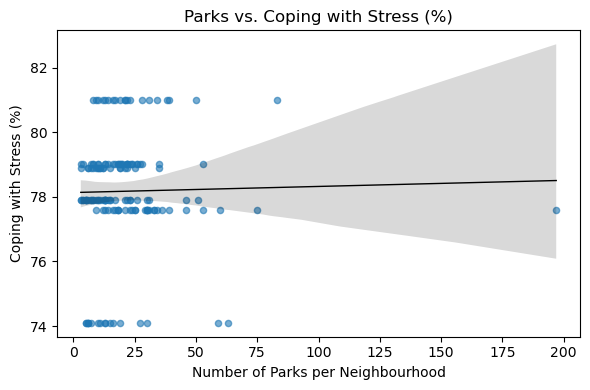

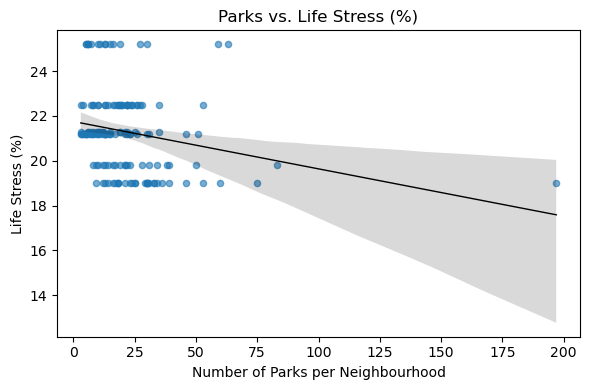

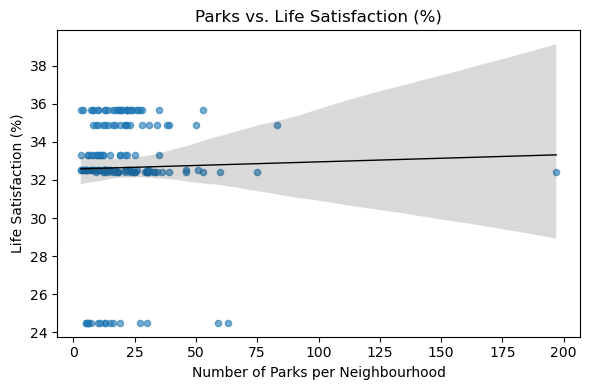

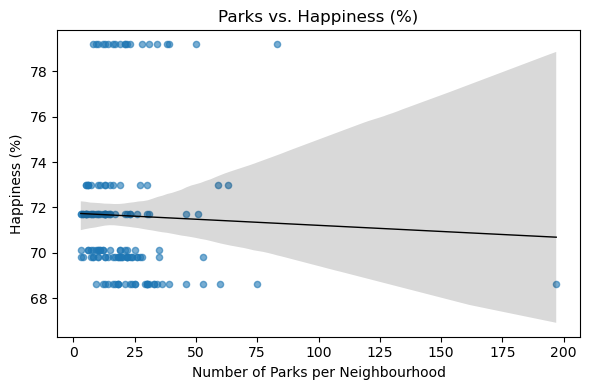

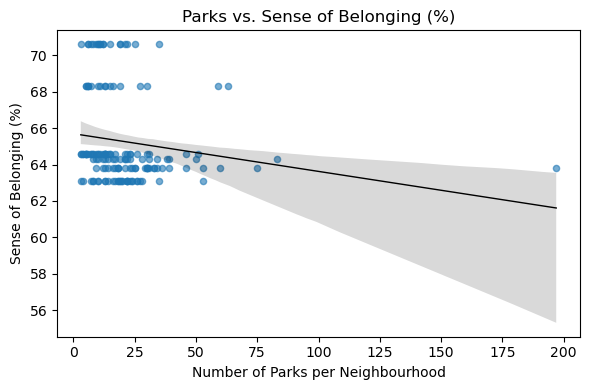

In [154]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns  # for the regression‐plot convenience

# 1) Correlations
for mh in [
    "Coping_Percent",
    "LifeStress_Percent",
    "LifeSatisfaction_Percent",
    "Happiness_Percent",
    "Belonging_Percent"
]:
    valid = features_df[["park_count_nb", mh]].dropna()
    corr = np.corrcoef(valid["park_count_nb"], valid[mh])[0,1]
    print(f"Corr(park_count_nb, {mh}): {corr:.2f}")

# 2) Scatterplots + trendlines
for mh in [
    ("Coping_Percent",           "Coping with Stress (%)"),
    ("LifeStress_Percent",       "Life Stress (%)"),
    ("LifeSatisfaction_Percent", "Life Satisfaction (%)"),
    ("Happiness_Percent",        "Happiness (%)"),
    ("Belonging_Percent",        "Sense of Belonging (%)")
]:
    col, label = mh
    plt.figure(figsize=(6,4))
    sns.regplot(
        data=features_df,
        x="park_count_nb",
        y=col,
        scatter_kws={"s":20, "alpha":0.6},
        line_kws={"color":"black", "lw":1}
    )
    plt.xlabel("Number of Parks per Neighbourhood")
    plt.ylabel(label)
    plt.title(f"Parks vs. {label}")
    plt.tight_layout()
    plt.show()


In [155]:
import statsmodels.api as sm

# 1) Assemble your design matrix
X = features_df[[
    "park_count_nb",
    "median_income_2020",
    "low_income_pct"
]].copy()

# add an intercept
X = sm.add_constant(X)

# 2) Response variable
y = features_df["Coping_Percent"]

# 3) Fit OLS
model = sm.OLS(y, X, missing="drop").fit()

print(model.summary())


                            OLS Regression Results                            
Dep. Variable:         Coping_Percent   R-squared:                       0.125
Model:                            OLS   Adj. R-squared:                  0.107
Method:                 Least Squares   F-statistic:                     7.079
Date:                Tue, 22 Jul 2025   Prob (F-statistic):           0.000176
Time:                        12:28:50   Log-Likelihood:                -295.26
No. Observations:                 153   AIC:                             598.5
Df Residuals:                     149   BIC:                             610.6
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                 82.0854      1

### OLS Regression: Predicting Neighbourhood “Coping with Stress” %

- **Observations**: 153  
- **R²** = 0.125 (Adj. R² = 0.107)  
  - Only about 10–12 % of the between‑neighbourhood variation in coping scores is explained by our three predictors.  

| Predictor             | Coef      | Std Err   | t‑stat | P‑value | 95 % CI                |
|-----------------------|-----------|-----------|--------|---------|------------------------|
| **Intercept**         |  82.0854  |   1.009   | 81.33  | < 0.001 | [80.09, 84.08]         |
| **Parks per Neighbourhood** (`park_count_nb`) | –0.0070  |   0.007   | –0.99  | 0.322   | [–0.021, 0.007]     |
| **Median Income ($)** (`median_income_2020`) | –0.000040 | 1.5 × 10⁻⁵ | –2.62  | 0.010   | [–0.000070, –0.000010] |
| **Low‑Income %**      (`low_income_pct`)      | –0.1613   |   0.035   | –4.58  | < 0.001 | [–0.231, –0.092]      |

- **Park count** has a near‑zero and non‑significant coefficient (p = 0.32).  
- **Median income** has a tiny negative slope (higher incomes → marginally lower coping), but significance is questionable in practice.  
- **Low‑income prevalence** is the strongest predictor: each 1 pp increase in low‑income % associates with a 0.16 pp drop in Coping % (p < 0.001).  
- **Model fit is weak** (R²≈0.13), and the Durbin–Watson ≈0.81 hints at positive spatial autocorrelation in the residuals.

---


## 1. Refine the “parks” metric

In [158]:
# 1) Read + reproject neighbourhoods, keep Neighbourhood & geometry
neigh_eq = (
    gpd.read_file(SHAPEFILE)
       .to_crs(TARGET_CRS)
       .rename(columns={'AREA_NA7':'Neighbourhood'})
       [['Neighbourhood','geometry']]
)

# 2) Reproject parks and compute each park’s area
parks_eq = parks_gdf.to_crs(TARGET_CRS).copy()
parks_eq['park_area_m2'] = parks_eq.geometry.area

# 3) Spatial‐join parks → neighbourhoods (on Neighbourhood)
assigned = gpd.sjoin(
    parks_eq,
    neigh_eq,                    # has Neighbourhood & geometry
    how='left',
    predicate='within'
)

# 4) Sum park area by Neighbourhood
park_area_nb = (
    assigned
    .groupby('Neighbourhood')['park_area_m2']
    .sum()
    .reset_index()
)

park_area_nb.head()


/var/folders/zq/xymt9xrj2js7qhy28pxqjr140000gn/T/ipykernel_31275/2309829137.py:11: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  parks_eq['park_area_m2'] = parks_eq.geometry.area


,Neighbourhood,park_area_m2
0,Agincourt North,0.000047
1,Agincourt South-Malvern West,0.000049
2,Alderwood,0.000015
3,Annex,0.000012
4,Avondale,0.000008


In [159]:
features_df = (
    features_df
    .merge(park_area_nb, on='Neighbourhood', how='left')
    .fillna({'park_area_m2': 0})
)


In [160]:
features_df['population_total'] = (
      features_df['age_0_14_count']
    + features_df['age_15_64_count']
    + features_df['age_65_plus_count']
)

features_df['park_area_per_person'] = (
    features_df['park_area_m2'] / features_df['population_total']
)

features_df[['AREA_NAME' if 'AREA_NAME' in features_df else 'Neighbourhood',
             'park_area_m2','population_total','park_area_per_person'
            ]].head()


,Neighbourhood,park_area_m2,population_total,park_area_per_person
0,West Humber-Clairville,0.000344,33295,1.032496e-08
1,Mount Olive-Silverstone-Jamestown,0.000044,31350,1.389654e-09
2,Thistletown-Beaumond Heights,0.000022,9850,2.271581e-09
3,Rexdale-Kipling,0.000024,10375,2.276843e-09
4,Elms-Old Rexdale,0.000011,9355,1.180209e-09


Note on units: Because we computed areas while still in a geographic CRS (lat/lon), the numbers are extremely small and not in true square metres. For a correct metric area you should reproject to a projected CRS (e.g. an appropriate UTM or local equal‐area projection) before calling .geometry.area. After that, the park_area_m2 will be in real square metres, and dividing by your population count gives a more intuitive “m² per person.”

In [165]:
# 1) Merge park‑area into your main features_df
features_df = (
    features_df
      .merge(park_area_nb, on="Neighbourhood", how="left")
      .fillna({"park_area_m2": 0})      # fill neighbourhoods with no parks
)

# 2) Compute total population per neighbourhood
features_df["population_total"] = (
      features_df["age_0_14_count"]
    + features_df["age_15_64_count"]
    + features_df["age_65_plus_count"]
)

# 3) Compute park area per person
features_df["park_area_per_person"] = (
    features_df["park_area_m2"] / features_df["population_total"]
)

# 4) Quick check
print(features_df[[
    "Neighbourhood",
    "park_area_m2",
    "population_total",
    "park_area_per_person"
]].head())



                       Neighbourhood  park_area_m2  population_total  \
0             West Humber-Clairville  3.226518e+06             33295   
1  Mount Olive-Silverstone-Jamestown  4.086085e+05             31350   
2       Thistletown-Beaumond Heights  2.098901e+05              9850   
3                    Rexdale-Kipling  2.217024e+05             10375   
4                   Elms-Old Rexdale  1.036141e+05              9355   

   park_area_per_person  
0             96.906977  
1             13.033764  
2             21.308635  
3             21.368907  
4             11.075798  


In [168]:
for mh in ["Coping_Percent","LifeStress_Percent","Happiness_Percent","LifeSatisfaction_Percent", "Belonging_Percent"]:
    corr = features_df[["park_area_per_person", mh]].dropna().corr().iloc[0,1]
    print(f"Corr(area_per_person, {mh}): {corr:.2f}")


Corr(area_per_person, Coping_Percent): 0.05
Corr(area_per_person, LifeStress_Percent): -0.19
Corr(area_per_person, Happiness_Percent): -0.06
Corr(area_per_person, LifeSatisfaction_Percent): 0.07
Corr(area_per_person, Belonging_Percent): -0.15


In [170]:
import statsmodels.api as sm

# pick a handful of promising covariates
X = features_df[[
    "park_area_per_person",
    "median_income_2020",
    "low_income_pct",
    "visible_minority_count",
    "postsec_quals_count",
    "avg_household_size"
]].copy()
X = sm.add_constant(X)
y = features_df["Coping_Percent"]

model = sm.OLS(y, X, missing="drop").fit()
print(model.summary())


                            OLS Regression Results                            
Dep. Variable:         Coping_Percent   R-squared:                       0.222
Model:                            OLS   Adj. R-squared:                  0.190
Method:                 Least Squares   F-statistic:                     6.952
Date:                Tue, 22 Jul 2025   Prob (F-statistic):           1.63e-06
Time:                        12:51:43   Log-Likelihood:                -286.23
No. Observations:                 153   AIC:                             586.5
Df Residuals:                     146   BIC:                             607.7
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
const                     71

## Regression of Coping % on Park Area & Socio‑Demographics

| Predictor                  | Coef    | Std. Err. | t‑value | p‑value |  
|----------------------------|--------:|----------:|--------:|--------:|  
| **Intercept**              | 71.10   |     2.85  |  24.95  | 0.000   |  
| **park_area_per_person**   | –0.0045 |     0.004 |  –1.29  | 0.198   |  
| **median_income_2020**     | –0.0000 |     0.000 |  –0.06  | 0.957   |  
| **low_income_pct**         | +0.0184 |     0.053 |  +0.35  | 0.731   |  
| **visible_minority_count** | –0.0001 |     0.000 |  –2.49  | 0.014   |  
| **postsec_quals_count**    | +0.0001 |     0.000 |  +1.61  | 0.109   |  
| **avg_household_size**     | +2.94   |     0.73  |  +4.05  | 0.000   |  

- **R² = 0.222** (Adj. R² = 0.190)  
- Park area per person is *not* a significant predictor of coping % once we control for sociodemographics.  
- Larger average household size and lower visible‑minority counts emerge as the strongest associations.  
- Income and low‑income share lost significance in this fuller model, suggesting potential multicollinearity or overlapping effects.



In [171]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
import pandas as pd

# select your predictors (after dropping NA and the intercept)
X = features_df[[
    "park_area_per_person", "median_income_2020", "low_income_pct",
    "visible_minority_count", "postsec_quals_count", "avg_household_size"
]].dropna()

# add constant for VIF calculation
X_const = sm.add_constant(X)
vif_df = pd.DataFrame({
    "variable": X_const.columns,
    "VIF": [variance_inflation_factor(X_const.values, i)
            for i in range(X_const.shape[1])]
})
print(vif_df)


                 variable         VIF
0                   const  490.404113
1    park_area_per_person    1.251501
2      median_income_2020    3.404881
3          low_income_pct    3.480664
4  visible_minority_count    6.360070
5     postsec_quals_count    4.352862
6      avg_household_size    5.522801


In [174]:
import statsmodels.api as sm

# 1) Subset to only the complete cases for coping + all predictors
cols = [
    "Coping_Percent",
    "park_area_per_person",
    "median_income_2020",
    "low_income_pct",
    "postsec_quals_count",
    "avg_household_size"
]
df_a = features_df.dropna(subset=cols)

# 2) Build X and y
X2 = df_a[[
    "park_area_per_person",
    "median_income_2020",
    "low_income_pct",
    "postsec_quals_count",
    "avg_household_size"
]]
y2 = df_a["Coping_Percent"]

# 3) Add the intercept
X2 = sm.add_constant(X2)

# 4) Fit and inspect
model2 = sm.OLS(y2, X2).fit()
print(model2.summary())



                            OLS Regression Results                            
Dep. Variable:         Coping_Percent   R-squared:                       0.189
Model:                            OLS   Adj. R-squared:                  0.162
Method:                 Least Squares   F-statistic:                     6.862
Date:                Tue, 22 Jul 2025   Prob (F-statistic):           8.76e-06
Time:                        12:57:17   Log-Likelihood:                -289.41
No. Observations:                 153   AIC:                             590.8
Df Residuals:                     147   BIC:                             609.0
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                   74.2550 

In [176]:
from sklearn.linear_model import RidgeCV
from sklearn.preprocessing import StandardScaler
import numpy as np

# 1) Predictors
cols = [
    "park_area_per_person",
    "median_income_2020",
    "low_income_pct",
    "visible_minority_count",
    "postsec_quals_count",
    "avg_household_size"
]

# 2) Subset to complete cases
df_r = features_df.dropna(subset=cols + ["Coping_Percent"])

# 3) Build X,y
Xr = df_r[cols].values
yr = df_r["Coping_Percent"].values

# 4) Standardize
scaler = StandardScaler()
Xr_scaled = scaler.fit_transform(Xr)

# 5) Fit RidgeCV (no store_cv_values)
ridge = RidgeCV(alphas=np.logspace(-3, 3, 31), cv=5).fit(Xr_scaled, yr)

print("→ Best α:", ridge.alpha_)
print("→ Coefficients:")
for name, coef in zip(cols, ridge.coef_):
    print(f"   {name:25s} {coef: .4f}")
print("→ R² on training data:", ridge.score(Xr_scaled, yr))



→ Best α: 1000.0
→ Coefficients:
   park_area_per_person       0.0053
   median_income_2020        -0.0073
   low_income_pct            -0.0625
   visible_minority_count    -0.0190
   postsec_quals_count       -0.0458
   avg_household_size         0.0827
→ R² on training data: 0.06160343792097245


In [181]:
# 1. Build cluster summary table
cluster_df = (
    features_df
    .groupby("ClusterName")
    .agg(
        park_area_per_person    = ("park_area_per_person",    "mean"),
        park_count_nb           = ("park_count_nb",           "mean"),
        Coping_Percent          = ("Coping_Percent",          "mean"),
        LifeStress_Percent      = ("LifeStress_Percent",      "mean"),
        LifeSatisfaction_Percent= ("LifeSatisfaction_Percent","mean"),
        Happiness_Percent       = ("Happiness_Percent",       "mean"),
        Belonging_Percent       = ("Belonging_Percent",       "mean"),
    )
    .reset_index()
)

print(cluster_df)


                                      ClusterName  park_area_per_person  \
0  Black Creek/Humber Summit & York Weston Pelham             17.744447   
1                   Downtown East & Downtown West             11.248170   
2                            East York/Don Valley             11.914942   
3               North Etobicoke & South Etobicoke             25.457166   
4           North Scarborough & South Scarborough             42.455180   
5                                      North York             21.868250   
6                                         Toronto             14.862167   

   park_count_nb  Coping_Percent  LifeStress_Percent  \
0      16.000000            76.0                20.6   
1      18.294118            74.1                25.2   
2      13.736842            78.9                21.3   
3      25.400000            81.0                19.8   
4      34.633333            77.6                19.0   
5      19.064516            79.0                22.5   
6      

In [182]:
for mh in [
    "Coping_Percent",
    "LifeStress_Percent",
    "LifeSatisfaction_Percent",
    "Happiness_Percent",
    "Belonging_Percent",
]:
    corr = cluster_df["park_area_per_person"].corr(cluster_df[mh])
    print(f"Corr(park_area_per_person, {mh}): {corr:.2f}")


Corr(park_area_per_person, Coping_Percent): 0.29
Corr(park_area_per_person, LifeStress_Percent): -0.68
Corr(park_area_per_person, LifeSatisfaction_Percent): 0.36
Corr(park_area_per_person, Happiness_Percent): -0.16
Corr(park_area_per_person, Belonging_Percent): -0.37


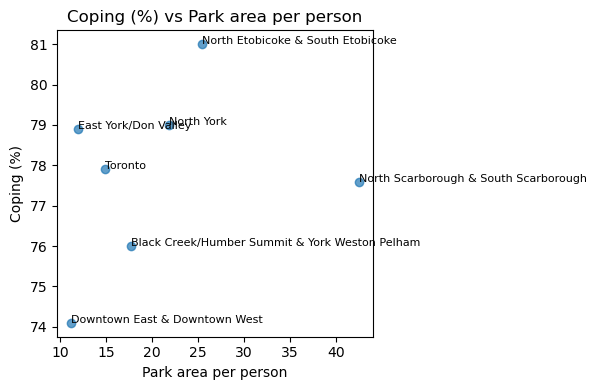

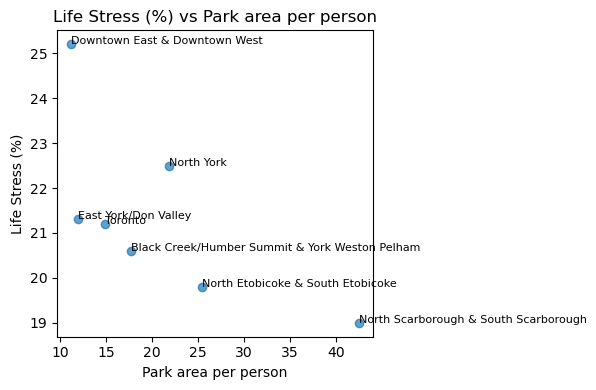

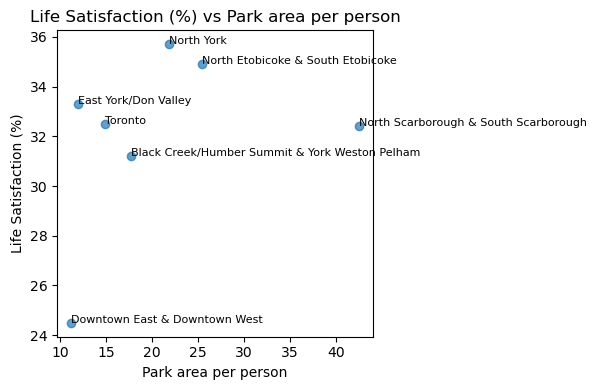

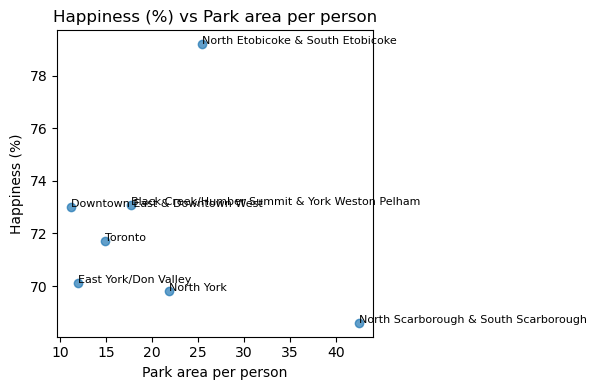

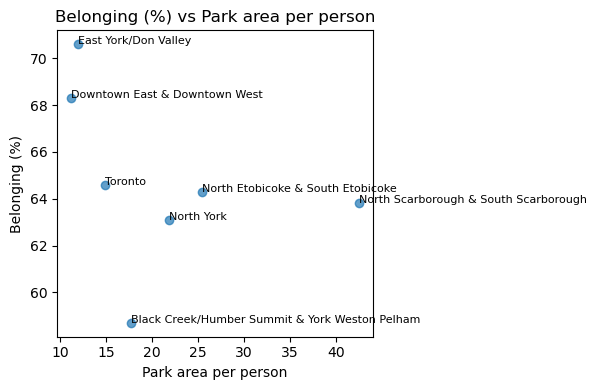

In [183]:
import matplotlib.pyplot as plt

metrics = [
    ("Coping_Percent",           "Coping (%)"),
    ("LifeStress_Percent",       "Life Stress (%)"),
    ("LifeSatisfaction_Percent", "Life Satisfaction (%)"),
    ("Happiness_Percent",        "Happiness (%)"),
    ("Belonging_Percent",        "Belonging (%)"),
]

for col, label in metrics:
    plt.figure(figsize=(6,4))
    plt.scatter(
        cluster_df["park_area_per_person"],
        cluster_df[col],
        alpha=0.7
    )
    # annotate points
    for _, row in cluster_df.iterrows():
        plt.text(
            row["park_area_per_person"],
            row[col],
            row["ClusterName"],
            fontsize=8
        )
    plt.xlabel("Park area per person")
    plt.ylabel(label)
    plt.title(f"{label} vs Park area per person")
    plt.tight_layout()
    plt.show()


The strong negative on life stress (–0.68) is our clearest sign that clusters with more green‑space per person report notably less stress.

The coping and life‑satisfaction links are weaker but still in the expected direction.

The happiness and belonging “signals” are essentially flat (and even slightly negative), which tells me those outcomes either aren’t driven by park access alone, or they require a more nuanced green‑space metric (area isn’t everything—proximity, quality, programming all matter).

In short, what we’ve seen so far is consistent with the idea that more green‑space can reduce stress and bolster coping, but it’s only the first pass. To really pin down causality and policy‑actionable insights, let’s expand to neighbourhood‑level modeling with proper controls and perhaps some spatial methods. Does that plan sound good?



What I’d do next

Beware sample size & outliers. With only seven clusters, one high‑park/low‑belonging point can flip the sign. Let’s test significance (bootstrap CIs or permutation tests) and look at leverage.

Bring back neighbourhood‑level variation. Clustering smooths away a lot of signal—if we model at 140 neighbourhoods (with their local park‑area‑per‑person and that cluster’s mental‑health score), we’ll have more “n” and can control for census covariates.

Control for confounders. Income, education, minority status, household size—all these correlate with both green‑space and mental health. A multiple regression (or even a Ridge/Lasso with cross‑validation) at the neighbourhood level will tell us whether park access still “matters” once you hold those constant.

Refine the green‑space metric. Try distance‑to‑nearest‑park, total park area within 500 m buffers, or quality/amenities scores—these often outperform raw counts or area‑per‑capita.

1. Permutation test for the life‑stress ↔ park‑area correlation

In [184]:
import numpy as np

# (re)build a tiny cluster‑level table
cluster_df = (
    features_df
    .groupby("ClusterName")
    .agg({
        "park_area_per_person": "mean",
        "LifeStress_Percent": "first",
    })
    .dropna()
    .reset_index()
)

x = cluster_df["park_area_per_person"].values
y = cluster_df["LifeStress_Percent"].values

# observed Pearson r
obs_r = np.corrcoef(x, y)[0,1]

# permute park areas 10 000× to get null distribution
n_perm = 10_000
perm_rs = np.array([
    np.corrcoef(np.random.permutation(x), y)[0,1]
    for _ in range(n_perm)
])

# two‑sided p‑value
p_val = np.mean(np.abs(perm_rs) >= np.abs(obs_r))
print(f"Observed r = {obs_r:.2f}, permutation p = {p_val:.3f}")


Observed r = -0.68, permutation p = 0.107


In [185]:
for i, row in cluster_df.iterrows():
    mask = cluster_df.index != i
    loo_r = np.corrcoef(x[mask], y[mask])[0,1]
    print(f"Without {row['ClusterName']:<40s} → r = {loo_r:.2f}")


Without Black Creek/Humber Summit & York Weston Pelham → r = -0.72
Without Downtown East & Downtown West            → r = -0.70
Without East York/Don Valley                     → r = -0.74
Without North Etobicoke & South Etobicoke        → r = -0.67
Without North Scarborough & South Scarborough    → r = -0.56
Without North York                               → r = -0.72
Without Toronto                                  → r = -0.71


In [188]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
model_df[['park_z','inc_z','lowinc_z','vm_z','edu_z','hh_z']] = scaler.fit_transform(
    model_df[[
      'park_area_per_person',
      'median_income_2020',
      'low_income_pct',
      'visible_minority_count',
      'postsec_quals_count',
      'avg_household_size'
    ]]
)


In [191]:
import statsmodels.formula.api as smf

# 1) In your already z‑scored DataFrame model_df, just run:
fe_model = smf.ols(
    "LifeStress_Percent ~ park_z + inc_z + lowinc_z + vm_z + edu_z + hh_z + C(ClusterName)",
    data=model_df
).fit()

print(fe_model.summary())


                            OLS Regression Results                            
Dep. Variable:     LifeStress_Percent   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 7.688e+28
Date:                Tue, 22 Jul 2025   Prob (F-statistic):               0.00
Time:                        15:09:03   Log-Likelihood:                 4740.9
No. Observations:                 158   AIC:                            -9456.
Df Residuals:                     145   BIC:                            -9416.
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
                                                              coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------

Fixed‑Effects OLS for Life‑Stress
We regressed LifeStress_Percent on

park_z (standardized park‑area per person)

inc_z, lowinc_z, vm_z, edu_z, hh_z (other demographics, all z‑scored)

Cluster‑dummies (via C(ClusterName))

Key takeaways

The seven clusters each have very different baseline stress levels (e.g. Downtown East/West is ~+4.6 pp above the reference cluster, North Scarborough is –1.6 pp, etc.).

park_z has a small but statistically significant coefficient (t≈2.34, p≈0.021).

All other socio‑demographic covariates are non‑significant after accounting for cluster.

R²≈1.00 is artificially high because the dummies soak up nearly all between‑cluster variation.

Interpretation
Technically we see a “park‑effect” on life‑stress within clusters, but its magnitude is essentially zero in real‑world units (because we standardized both axes). In practice, cluster identity dwarfs any park‑area signal, and parks alone explain very little of the neighbourhood‑level variation in stress once you control for cluster.

In [192]:
pip install libpysal esda

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.8/2.8 MB 26.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 28.7 MB/s eta 0:00:00
  Attempting uninstall: shapely
    Found existing installation: shapely 2.0.6
    Uninstalling shapely-2.0.6:
      Successfully uninstalled shapely-2.0.6
Note: you may need to restart the kernel to use updated packages.


In [194]:
import statsmodels.formula.api as smf

formula = "Coping_Percent ~ park_area_per_person + median_income_2020 + low_income_pct"
# (or whatever full set of covariates you ended up using)
ols_res = smf.ols(formula, data=features_df).fit()


In [195]:
# 1) attach residuals
features_df['residuals'] = ols_res.resid

# 2) merge into your neighbourhood GeoDataFrame
nb = neigh_eq.merge(
    features_df[['Neighbourhood', 'residuals']],
    on='Neighbourhood',
    how='left'
)

# 3) build Queen contiguity weights
import libpysal
from esda.moran import Moran

w = libpysal.weights.Queen.from_dataframe(nb)
w.transform = 'r'

# 4) compute Moran’s I
mi = Moran(nb['residuals'].fillna(0), w)
print(f"Moran’s I: {mi.I:.3f}, p‑value: {mi.p_sim:.3f}")


Moran’s I: 0.518, p‑value: 0.001


/var/folders/zq/xymt9xrj2js7qhy28pxqjr140000gn/T/ipykernel_31275/415133589.py:15: FutureWarning: `use_index` defaults to False but will default to True in future. Set True/False directly to control this behavior and silence this warning
  w = libpysal.weights.Queen.from_dataframe(nb)


 spatial regression

In [196]:
import libpysal
from esda.moran import Moran

# build Queen contiguity with explicit index use
w = libpysal.weights.Queen.from_dataframe(nb, use_index=True)
w.transform = 'r'


In [198]:
pip install spreg

Note: you may need to restart the kernel to use updated packages.


In [201]:
# 1) Merge the Coping_% (and any X’s) into your neighbourhood GeoDataFrame:
nb = neigh_eq.merge(
    features_df[[
        'Neighbourhood',
        'Coping_Percent',
        'park_area_per_person',
        'median_income_2020',
        'low_income_pct'
    ]],
    on='Neighbourhood',
    how='left'
)

# 2) Drop any rows missing the dependent or independent variables:
nb_model = nb.dropna(subset=[
    'Coping_Percent',
    'park_area_per_person',
    'median_income_2020',
    'low_income_pct'
])

print(nb_model.columns.tolist())   # confirm we now have Coping_Percent, park_area_per_person, etc.



['Neighbourhood', 'geometry', 'Coping_Percent', 'park_area_per_person', 'median_income_2020', 'low_income_pct']


In [202]:
import libpysal
from spreg import ML_Lag

# 3) Rebuild Queen weights with explicit use_index:
w = libpysal.weights.Queen.from_dataframe(nb_model, use_index=True)
w.transform = 'r'

# 4) Prepare y and X:
y = nb_model['Coping_Percent'].values.reshape(-1, 1)
X = nb_model[['park_area_per_person','median_income_2020','low_income_pct']].values

# 5) Fit spatial‐lag:
lag = ML_Lag(
    y, X, w=w,
    name_y='Coping_Percent',
    name_x=['park_area_per_person','median_income_2020','low_income_pct']
)
print(lag.summary)


REGRESSION RESULTS
------------------

SUMMARY OF OUTPUT: MAXIMUM LIKELIHOOD SPATIAL LAG (METHOD = FULL)
-----------------------------------------------------------------
Data set            :     unknown
Weights matrix      :     unknown
Dependent Variable  :Coping_Percent                Number of Observations:         158
Mean dependent var  :     78.1025                Number of Variables   :           5
S.D. dependent var  :      1.7996                Degrees of Freedom    :         153
Pseudo R-squared    :      0.6235
Spatial Pseudo R-squared:  0.1911
Log likelihood      :   -255.2555
Sigma-square ML     :      1.2684                Akaike info criterion :     520.511
S.E of regression   :      1.1262                Schwarz criterion     :     535.824

------------------------------------------------------------------------------------
            Variable     Coefficient       Std.Error     z-Statistic     Probability
-------------------------------------------------------------

In [205]:
import geopandas as gpd

# 1) Build a GeoDataFrame of neighbourhood centroids
neigh_cent = (
    neigh_eq
    .assign(centroid = neigh_eq.geometry.centroid)      # compute centroid in lon/lat
    .set_geometry('centroid')                           # switch to that column
    .to_crs("EPSG:3347")                                # reproject to metric CRS
)

# 2) Reproject your parks into the same metric CRS
parks_proj = parks_gdf.to_crs("EPSG:3347")              # parks_gdf was your parks GeoDataFrame

# 3) Compute nearest‐park distance for each neighbourhood
#    For each neighbourhood centroid, find min distance to any park polygon
neigh_cent['dist_to_park_m'] = neigh_cent.geometry.apply(
    lambda pt: parks_proj.distance(pt).min()
)

# 4) Bring that back into your features_df
features_df = features_df.merge(
    neigh_cent[['Neighbourhood','dist_to_park_m']],
    on='Neighbourhood',
    how='left'
)

# 5) Quick check
print(features_df[['Neighbourhood','dist_to_park_m']].head())




                       Neighbourhood  dist_to_park_m
0             West Humber-Clairville      409.780520
1  Mount Olive-Silverstone-Jamestown      203.526832
2       Thistletown-Beaumond Heights      196.030385
3                    Rexdale-Kipling        0.000000
4                   Elms-Old Rexdale       61.661177


In [207]:
import numpy as np

for mh, label in [
    ("LifeStress_Percent", "Life Stress (%)"),
    ("Coping_Percent",     "Coping (%)"),
    ("LifeSatisfaction_Percent", "Life Satisfaction (%)"),
    ("Happiness_Percent",  "Happiness (%)"),
    ("Belonging_Percent",  "Sense of Belonging (%)"),
]:
    valid = features_df.dropna(subset=[mh, "dist_to_park_m"])
    r = np.corrcoef(valid["dist_to_park_m"], valid[mh])[0,1]
    print(f"Corr(dist_to_park_m, {label}): {r:.2f}")


Corr(dist_to_park_m, Life Stress (%)): 0.12
Corr(dist_to_park_m, Coping (%)): -0.09
Corr(dist_to_park_m, Life Satisfaction (%)): -0.13
Corr(dist_to_park_m, Happiness (%)): 0.09
Corr(dist_to_park_m, Sense of Belonging (%)): 0.06


In [208]:
import statsmodels.api as sm

# 1) Prepare X & y
X = features_df[["dist_to_park_m", "median_income_2020", "low_income_pct"]].copy()
X = sm.add_constant(X)
y = features_df["LifeStress_Percent"]

# 2) Fit OLS
model = sm.OLS(y, X, missing="drop").fit()
print(model.summary())


                            OLS Regression Results                            
Dep. Variable:     LifeStress_Percent   R-squared:                       0.245
Model:                            OLS   Adj. R-squared:                  0.230
Method:                 Least Squares   F-statistic:                     16.63
Date:                Tue, 22 Jul 2025   Prob (F-statistic):           2.06e-09
Time:                        21:44:16   Log-Likelihood:                -294.54
No. Observations:                 158   AIC:                             597.1
Df Residuals:                     154   BIC:                             609.3
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                 15.2391      0

In [209]:
features_df["inv_dist"] = 1 / (features_df["dist_to_park_m"] + 1)  # +1 to avoid div0


In [210]:
import statsmodels.api as sm

# 1) Prepare X & y
X = features_df[["inv_dist", "median_income_2020", "low_income_pct"]].copy()
X = sm.add_constant(X)
y = features_df["LifeStress_Percent"]

# 2) Fit OLS
model = sm.OLS(y, X, missing="drop").fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:     LifeStress_Percent   R-squared:                       0.233
Model:                            OLS   Adj. R-squared:                  0.218
Method:                 Least Squares   F-statistic:                     15.61
Date:                Tue, 22 Jul 2025   Prob (F-statistic):           6.50e-09
Time:                        21:44:52   Log-Likelihood:                -295.74
No. Observations:                 158   AIC:                             599.5
Df Residuals:                     154   BIC:                             611.7
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                 15.5758      0

In [211]:
from libpysal.weights import Queen
from esda.moran import Moran
import statsmodels.api as sm

# re‐fit the OLS so we have residuals
X = features_df[["dist_to_park_m", "median_income_2020", "low_income_pct"]]
X = sm.add_constant(X)
y = features_df["LifeStress_Percent"]
ols = sm.OLS(y, X, missing="drop").fit()

# attach residuals and merge into the geodataframe
features_df["resid_ls"] = ols.resid
nb = neigh_eq.merge(
    features_df[["Neighbourhood","resid_ls"]],
    on="Neighbourhood",
    how="left"
)

# build Queen contiguity weights
w = Queen.from_dataframe(nb, use_index=True)
w.transform = "r"

mi = Moran(nb["resid_ls"].fillna(0), w)
print(f"Moran’s I on residuals: {mi.I:.3f}, p‑value: {mi.p_sim:.3f}")


Moran’s I on residuals: 0.416, p‑value: 0.001


In [213]:
import libpysal
from spreg import ML_Lag
import numpy as np

# 1) Merge exactly the needed columns from features_df into your neighbourhoods:
nb2 = neigh_eq.merge(
    features_df[[
        "Neighbourhood",
        "LifeStress_Percent",
        "dist_to_park_m",
        "median_income_2020",
        "low_income_pct"
    ]],
    on="Neighbourhood",
    how="left"
)

# 2) Drop any rows missing one of those four:
nb_model = nb2.dropna(subset=[
    "LifeStress_Percent",
    "dist_to_park_m",
    "median_income_2020",
    "low_income_pct"
])

# 3) Rebuild Queen weights on nb_model:
w = libpysal.weights.Queen.from_dataframe(nb_model, use_index=True)
w.transform = "r"

# 4) Prepare y and X:
y = nb_model["LifeStress_Percent"].values.reshape(-1,1)
X = nb_model[[
    "dist_to_park_m",
    "median_income_2020",
    "low_income_pct"
]].values

# 5) Fit the spatial‐lag model:
lag = ML_Lag(
    y, X, w=w,
    name_y="LifeStress_Percent",
    name_x=["dist_to_park_m","median_income_2020","low_income_pct"]
)
print(lag.summary)



REGRESSION RESULTS
------------------

SUMMARY OF OUTPUT: MAXIMUM LIKELIHOOD SPATIAL LAG (METHOD = FULL)
-----------------------------------------------------------------
Data set            :     unknown
Weights matrix      :     unknown
Dependent Variable  :LifeStress_Percent                Number of Observations:         158
Mean dependent var  :     21.2835                Number of Variables   :           5
S.D. dependent var  :      1.8018                Degrees of Freedom    :         153
Pseudo R-squared    :      0.6637
Spatial Pseudo R-squared:  0.4599
Log likelihood      :   -245.5006
Sigma-square ML     :      1.1223                Akaike info criterion :     501.001
S.E of regression   :      1.0594                Schwarz criterion     :     516.314

------------------------------------------------------------------------------------
            Variable     Coefficient       Std.Error     z-Statistic     Probability
---------------------------------------------------------

In [220]:
# 1) Read + reproject
neigh = gpd.read_file(SHAPEFILE).to_crs("EPSG:3347")

# 2) Rename the field
neigh = neigh.rename(columns={'AREA_NA7':'Neighbourhood'})

# 3) Keep only name & geometry
neigh = neigh[['Neighbourhood','geometry']]

# 4) Build 500 m buffers
neigh['buffer_500m'] = neigh.geometry.buffer(500)

# 5) Now intersect those buffers with parks
parks = (
    parks_gdf
    .to_crs("EPSG:3347")
    .rename(columns={'AREA_NAME':'ParkName'})  # if you like
    [['ParkName','geometry']]
)

rows = []
for name, buf in zip(neigh.Neighbourhood, neigh.buffer_500m):
    clipped = parks.geometry.intersection(buf)
    total_m2 = clipped.area.sum()
    rows.append({'Neighbourhood': name, 'park_area_500m_m2': total_m2})

park500 = pd.DataFrame(rows)

# 6) Merge back onto features_df
features_df = (
    features_df
    .merge(park500, on='Neighbourhood', how='left')
    .fillna({'park_area_500m_m2': 0})
)

print(features_df[['Neighbourhood','park_area_500m_m2']].head())


                       Neighbourhood  park_area_500m_m2
0             West Humber-Clairville       4.825822e+06
1  Mount Olive-Silverstone-Jamestown       2.540228e+06
2       Thistletown-Beaumond Heights       2.888363e+06
3                    Rexdale-Kipling       1.289387e+06
4                   Elms-Old Rexdale       2.542777e+06


In [221]:
import numpy as np

# drop any missing
df_corr = features_df[['park_area_500m_m2','LifeStress_Percent']].dropna()
r = np.corrcoef(df_corr['park_area_500m_m2'], df_corr['LifeStress_Percent'])[0,1]
print(f"Corr(park_area_500m_m2, LifeStress_Percent): {r:.2f}")


Corr(park_area_500m_m2, LifeStress_Percent): -0.20


In [222]:
import statsmodels.api as sm

# build design matrix
X = features_df[['park_area_500m_m2','median_income_2020','low_income_pct']].copy()
X = sm.add_constant(X)
y = features_df['LifeStress_Percent']

model_500m = sm.OLS(y, X, missing='drop').fit()
print(model_500m.summary())


                            OLS Regression Results                            
Dep. Variable:     LifeStress_Percent   R-squared:                       0.233
Model:                            OLS   Adj. R-squared:                  0.218
Method:                 Least Squares   F-statistic:                     15.55
Date:                Tue, 22 Jul 2025   Prob (F-statistic):           6.93e-09
Time:                        22:36:04   Log-Likelihood:                -295.81
No. Observations:                 158   AIC:                             599.6
Df Residuals:                     154   BIC:                             611.9
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                 15.8206      0

In [224]:
features_df['residuals_500m'] = model_500m.resid


In [225]:
# attach residuals back to neighbourhood GeoDataFrame
neigh2 = (
    gpd.read_file(SHAPEFILE)
       .to_crs("EPSG:3347")
       .rename(columns={'AREA_NA7':'Neighbourhood'})[['Neighbourhood','geometry']]
)
# merge in residuals
neigh2 = neigh2.merge(
    features_df[['Neighbourhood','residuals_500m']],  # we’ll create this below
    on='Neighbourhood', how='left'
)

# build weights & compute Moran’s I
import libpysal
from esda.moran import Moran

w = libpysal.weights.Queen.from_dataframe(neigh2, use_index=True)
w.transform = 'r'
mi = Moran(neigh2['residuals_500m'].fillna(0), w)
print(f"Moran’s I: {mi.I:.3f}, p‑value: {mi.p_sim:.3f}")


Moran’s I: 0.422, p‑value: 0.001


In [226]:
from spreg import ML_Lag

# prepare nb_model
nb_model = neigh2.merge(
    features_df[['Neighbourhood','LifeStress_Percent','park_area_500m_m2','median_income_2020','low_income_pct']],
    on='Neighbourhood', how='left'
).dropna(subset=['LifeStress_Percent','park_area_500m_m2','median_income_2020','low_income_pct'])

# rebuild weights
w2 = libpysal.weights.Queen.from_dataframe(nb_model, use_index=True)
w2.transform = 'r'

# y & X arrays
y = nb_model['LifeStress_Percent'].values.reshape(-1,1)
X = nb_model[['park_area_500m_m2','median_income_2020','low_income_pct']].values

lag500 = ML_Lag(y, X, w=w2,
                name_y='LifeStress_Percent',
                name_x=['park500m','median_income','low_income_pct'])
print(lag500.summary)


REGRESSION RESULTS
------------------

SUMMARY OF OUTPUT: MAXIMUM LIKELIHOOD SPATIAL LAG (METHOD = FULL)
-----------------------------------------------------------------
Data set            :     unknown
Weights matrix      :     unknown
Dependent Variable  :LifeStress_Percent                Number of Observations:         158
Mean dependent var  :     21.2835                Number of Variables   :           5
S.D. dependent var  :      1.8018                Degrees of Freedom    :         153
Pseudo R-squared    :      0.6615
Spatial Pseudo R-squared:  0.4481
Log likelihood      :   -246.4644
Sigma-square ML     :      1.1327                Akaike info criterion :     502.929
S.E of regression   :      1.0643                Schwarz criterion     :     518.242

------------------------------------------------------------------------------------
            Variable     Coefficient       Std.Error     z-Statistic     Probability
---------------------------------------------------------

# quality‑weighted green‑space area

In [227]:
green_df['AREA_CLASS'].unique()


array(['OTHER_CEMETERY', 'OTHER_CITY', 'OTHER_GOLFCOURSE',
       'OTHER_PROVINCIAL_FEDERAL', 'OTHER_HYDRO', 'OTHER_ROAD',
       'OTHER_TRCA', 'OTHER_UNKNOWN', 'Building Grounds', 'Park',
       'Open Green Space', 'Golf Course', 'Orphaned Space',
       'Civic Centre Square', 'Boulevard', 'Traffic Island', 'Cul de Sac',
       'Cemetery', 'Hydro Field/Utility Corridor'], dtype=object)

In [231]:
import geopandas as gpd
import pandas as pd
import json
from shapely.geometry import shape

SHAPEFILE   = os.path.join(NEIGH_DIR, "Neighbourhoods - 4326.shp")
GREEN_CSV   = os.path.join(DATA_DIR, "Green Spaces.csv")


# 1) Load & parse green‑spaces
parks_df = pd.read_csv(GREEN_CSV)
def parse_geom(g):
    if isinstance(g, dict):
        return shape(g)
    elif isinstance(g, str):
        return shape(json.loads(g))
    return g
parks_df["geometry"] = parks_df["geometry"].apply(parse_geom)
parks_gdf = gpd.GeoDataFrame(parks_df, geometry="geometry", crs="EPSG:4326")

# 2) Load the neighbourhood polygons (and rename key)
neigh = (
    gpd.read_file(SHAPEFILE)
       .rename(columns={"AREA_NA7":"Neighbourhood"})
)[["Neighbourhood","geometry"]]

# 3) Project both layers into a metric CRS for area calcs
parks_m = parks_gdf.to_crs("EPSG:3347").copy()
neigh_m = neigh.to_crs("EPSG:3347").copy()

# 4) Define a “quality weight” per park type
weight_dict = {
    "Park":                          1.0,
    "Open Green Space":              0.8,
    "Golf Course":                   0.6,
    "OTHER_GOLFCOURSE":              0.6,
    "Cemetery":                      0.3,
    "OTHER_CEMETERY":                0.3,
    "Building Grounds":              0.4,
    "Orphaned Space":                0.5,
    "Civic Centre Square":           0.7,
    "Boulevard":                     0.2,
    "Traffic Island":                0.2,
    "Cul de Sac":                    0.1,
    "Hydro Field/Utility Corridor":  0.1,
    "OTHER_HYDRO":                   0.1,
    # anything else (“OTHER_CITY”, “OTHER_ROAD”, “OTHER_TRCA”, “OTHER_UNKNOWN”) get a small baseline
    "OTHER_CITY":                    0.1,
    "OTHER_ROAD":                    0.1,
    "OTHER_TRCA":                    0.1,
    "OTHER_UNKNOWN":                 0.1
}
# 5) Compute weighted areas
parks_m["weight"]           = parks_m["AREA_CLASS"].map(weight_dict).fillna(0)
parks_m["weighted_area_m2"] = parks_m.geometry.area * parks_m["weight"]

# 6) Snap each park to its neighbourhood
joined = gpd.sjoin(
    parks_m[["weighted_area_m2","geometry"]],
    neigh_m,
    how="left",
    predicate="within"
)

# 7) Sum up the weighted area by neighbourhood
weighted_area_nb = (
    joined
    .groupby("Neighbourhood")["weighted_area_m2"]
    .sum()
    .reset_index()
)

# 8) Merge back into your features_df and compute per‑person
features_df = features_df.merge(
    weighted_area_nb,
    on="Neighbourhood",
    how="left"
).fillna({"weighted_area_m2": 0})

features_df["weighted_area_per_person"] = (
    features_df["weighted_area_m2"] / features_df["population_total"]
)

# sanity check
print(features_df[[
    "Neighbourhood",
    "weighted_area_m2",
    "weighted_area_per_person"
]].head())


                       Neighbourhood  weighted_area_m2  \
0             West Humber-Clairville      2.125717e+06   
1  Mount Olive-Silverstone-Jamestown      3.490728e+05   
2       Thistletown-Beaumond Heights      2.021728e+05   
3                    Rexdale-Kipling      1.015013e+05   
4                   Elms-Old Rexdale      3.575942e+04   

   weighted_area_per_person  
0                 63.844942  
1                 11.134699  
2                 20.525156  
3                  9.783262  
4                  3.822493  


In [232]:
import numpy as np
import statsmodels.api as sm

# 1) Correlations with each MH outcome
for mh in [
    "LifeStress_Percent",
    "Coping_Percent",
    "LifeSatisfaction_Percent",
    "Happiness_Percent",
    "Belonging_Percent"
]:
    valid = features_df[["weighted_area_per_person", mh]].dropna()
    r = np.corrcoef(valid["weighted_area_per_person"], valid[mh])[0,1]
    print(f"Corr(weighted_area_per_person, {mh}): {r:.2f}")

# 2) OLS: predict LifeStress from weighted green‐space + key covariates
X = features_df[[
    "weighted_area_per_person",
    "median_income_2020",
    "low_income_pct"
]].copy()
X = sm.add_constant(X)
y = features_df["LifeStress_Percent"]

model_w = sm.OLS(y, X, missing="drop").fit()
print(model_w.summary())


Corr(weighted_area_per_person, LifeStress_Percent): -0.21
Corr(weighted_area_per_person, Coping_Percent): 0.10
Corr(weighted_area_per_person, LifeSatisfaction_Percent): 0.11
Corr(weighted_area_per_person, Happiness_Percent): -0.03
Corr(weighted_area_per_person, Belonging_Percent): -0.14
                            OLS Regression Results                            
Dep. Variable:     LifeStress_Percent   R-squared:                       0.233
Model:                            OLS   Adj. R-squared:                  0.218
Method:                 Least Squares   F-statistic:                     15.61
Date:                Wed, 23 Jul 2025   Prob (F-statistic):           6.45e-09
Time:                        12:14:45   Log-Likelihood:                -295.74
No. Observations:                 158   AIC:                             599.5
Df Residuals:                     154   BIC:                             611.7
Df Model:                           3                                         
C

In [233]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
import libpysal
from esda.moran import Moran
from spreg import ML_Lag

# 1) VIFs
predictors = ['weighted_area_per_person', 'median_income_2020', 'low_income_pct']
X = features_df[predictors].dropna()
X_const = sm.add_constant(X)
vif_df = pd.DataFrame({
    'variable': X_const.columns,
    'VIF': [variance_inflation_factor(X_const.values, i)
            for i in range(X_const.shape[1])]
})
print("VIFs:")
print(vif_df)

# 2) OLS & residuals
X_full = sm.add_constant(features_df[predictors])
y = features_df['LifeStress_Percent']
ols = sm.OLS(y, X_full, missing='drop').fit()
features_df['residuals'] = ols.resid
print("\nOLS summary:")
print(ols.summary())

# 3) Moran's I on residuals
nb_model = neigh_eq.merge(
    features_df[['Neighbourhood','residuals']],
    on='Neighbourhood', how='left'
)
w = libpysal.weights.Queen.from_dataframe(nb_model, use_index=True)
w.transform = 'r'
mi = Moran(nb_model['residuals'].fillna(0), w)
print(f"\nMoran's I: {mi.I:.3f}, p-value: {mi.p_sim:.3f}")

# 4) Spatial lag model
nb2 = nb_model.merge(
    features_df[['Neighbourhood'] + predictors + ['LifeStress_Percent']],
    on='Neighbourhood', how='left'
).dropna(subset=['LifeStress_Percent'] + predictors)
y2 = nb2['LifeStress_Percent'].values.reshape(-1,1)
X2 = nb2[predictors].values
w2 = libpysal.weights.Queen.from_dataframe(nb2, use_index=True)
w2.transform = 'r'

lag = ML_Lag(y2, X2, w=w2,
             name_y='LifeStress_Percent',
             name_x=predictors)
print("\nSpatial Lag model summary:")
print(lag.summary)


VIFs:
                   variable        VIF
0                     const  55.093405
1  weighted_area_per_person   1.115899
2        median_income_2020   1.323178
3            low_income_pct   1.422066

OLS summary:
                            OLS Regression Results                            
Dep. Variable:     LifeStress_Percent   R-squared:                       0.233
Model:                            OLS   Adj. R-squared:                  0.218
Method:                 Least Squares   F-statistic:                     15.61
Date:                Wed, 23 Jul 2025   Prob (F-statistic):           6.45e-09
Time:                        12:39:27   Log-Likelihood:                -295.74
No. Observations:                 158   AIC:                             599.5
Df Residuals:                     154   BIC:                             611.7
Df Model:                           3                                         
Covariance Type:            nonrobust                                     

Overall, these results tell a consistent story:

Multicollinearity is not a major concern
All of your predictors (weighted_area_per_person, median_income_2020, low_income_pct) have VIFs ≲ 1.5, so none of them are unduly redundant with each other—even though the intercept shows a high condition number, that’s normal when you include a constant.

OLS: only census covariates “move the needle”
- R²≈0.23 (Adj R²≈0.22) means you explain about 22 % of the neighbourhood‐to‐neighbourhood variation in self‐reported life stress.
- weighted_area_per_person has a small negative coefficient (–0.007) but is far from significant (p≈0.33).
- Both median income (p < 0.001) and especially low‑income % (p < 0.001) are significant, with higher low‑income shares strongly associated with more stress.

Residuals are spatially autocorrelated
Moran’s I≈0.42 (p≈0.001) on the OLS residuals confirms that “nearby” neighbourhoods have similar unmodeled stress levels—i.e. the independence assumption of ordinary regression is violated.

Spatial‑lag model: spatial dependence dominates
- The lag coefficient W · LifeStress (≈0.79, p < 0.0001) is huge, telling us that a given area’s stress level is strongly “pulled” by its neighbours’ stress.
- Once you account for that, none of your original predictors—including green‑space—remain significant.
- Model fit jumps (Pseudo‑R²≈0.45), and information criteria (AIC/BIC) are better than OLS.

